<a href="https://colab.research.google.com/github/tedteske/bounded_lognorm/blob/master/bounded_lognorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

The **bounded lognormal** is a continuous probability distribution derived from the [lognormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution). Unlike the normal and lognormal distributions, the  support of the bounded lognormal may have both upper and lower bounds, and it may be symmetrical or skewed, depending on the parameters. It therefore may be a good fit for many natural phenomena, for which the range of possible values is limited, for example adult height and running speed. 

The lognormal probability density function (pdf) is often defined in terms of $\mu_N$ and $\sigma_N$, the mean and standard deviation of some normal distribution $N$:


$$
f_L(x, \mu_N, \sigma_N ) = \frac{1}{x \sigma_N \sqrt{2 \pi}} \times exp(\frac{-(\ln(x) - \mu_N)^2}{2\sigma_N^2}) \tag{1}
$$

If we redefine $f_L$ in terms of mode $m$ and standard deviation $\sigma$ as $f_{L'}$, then the bounded lognormal pdf $f_{BL}$ is the piecewise function:

$$
f_{BL}(x, m, \sigma, upper) =
  \begin{cases}
    f_{L'}(x, m, \sigma)   &  \text{for } x <= m \\
    f_{L'}(upper-x, upper-m, \sigma)   &  \text{for } x > m \\
  \end{cases} \tag{2}
$$

where the second piece is scaled so that $f_{BL}$ is continuous at the mode, and $(lower, upper)$ are the lower and upper bounds of the support.

### Python Implementation: Class Definition

The bounded lognormal distribution is implemented in Python as an instance of the [scipy.stats.rv_continuous](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous) class and inherits from it a collection of generic methods.

In [2]:
#
# Author: Ted Teske 2020-2021 
#          

from scipy.stats import rv_continuous
from scipy.special import erf, erfinv
from scipy.optimize import curve_fit, minimize
import numpy as np

"""
The following optional imports and plotting settings are for the examples
below, but are not necessary for the class definition itself.
"""
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from scipy.stats import norm, truncnorm, lognorm, beta 
from scipy.stats import skew, kurtosis, normaltest, probplot
from scipy.interpolate import interp1d
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = [10, 10/1.6]
"""
End of optional section.
"""


def lognorm_pdf(x, mu_N=0, sigma_N=1):
    """
    Log-normal (aka lognormal) probability density function (pdf).

    Parameters
    ----------
    x : {float, list or ndarray of floats}
        x-value(s)
    mu_N : float
        mean of underlying normal distribution
    sigma_N : float
        standard deviation of underlying normal distribution

    Returns
    -------
    y : ndarray of float(s)

    References
    ----------
    [1] https://en.wikipedia.org/wiki/Log-normal_distribution
    """
    # Creates an index of positive elements in x.
    x = np.atleast_1d(x)
    i = np.nonzero(x > 0)

    # Applies lognormal pdf to positive elements. All others evaluate to 0.
    y = np.zeros(len(x))
    y[i] = 1 / (x[i] * sigma_N * np.sqrt(2 * np.pi)) \
        * np.exp(-(np.log(x[i]) - mu_N)**2 / (2 * sigma_N**2))
    return y


def lognorm_cdf(x, mu_N=0, sigma_N=1):
    """
    Log-normal cumulative density function (cdf).

    Parameters
    ----------
    x : {float, list or ndarray of floats}
        x-value(s)
    mu_N : float
        mean of underlying normal distribution
    sigma_N : float
        standard deviation of underlying normal distribution

    Returns
    -------
    y : ndarray of float(s)

    References
    ----------
    [1] https://en.wikipedia.org/wiki/Log-normal_distribution
    """
    # Creates an index of positive elements in x.
    x = np.atleast_1d(x)
    i = np.nonzero(x > 0)

    # Applies lognormal cdf to positive elements. All others evaluate to 0.
    y = np.zeros(len(x))
    y[i] = 0.5 + 0.5 * erf((np.log(x[i]) - mu_N) / (np.sqrt(2) * sigma_N))
    return y


def lognorm_ppf(q, mu_N=0, sigma_N=1):
    """
    Log-normal percent-point function (ppf), also known as the quantile 
    function, is the inverse of the cdf.

    Parameters
    ----------
    q : {float, list or ndarray of floats}
        quantile(s)
    mu_N : float
        mean of underlying normal distribution
    sigma_N : float
        standard deviation of underlying normal distribution

    Returns
    -------
    y : ndarray of float(s)

    References
    ----------
    [1] https://en.wikipedia.org/wiki/Log-normal_distribution
    """
    y = np.exp(mu_N + np.sqrt(2 * sigma_N**2) * erfinv(2 * q - 1))
    return y


def norm_pdf(x, mu_N=0, sigma_N=1):
    """
    Normal probability density function (pdf).

    Parameters
    ----------
    x : {float, list or ndarray of floats}
        x-value(s)
    mu_N : float
        mean 
    sigma_N : float
        standard deviation 

    Returns
    -------
    y : ndarray of float(s)

    References
    ----------
    [1] https://en.wikipedia.org/wiki/Normal_distribution
    """
    y = 1 / (sigma_N * np.sqrt(2 * np.pi))
    y *= np.exp(-(x - mu_N)**2 / (2 * sigma_N**2))
    return y


def norm_cdf(x, mu_N=0, sigma_N=1):
    """
    Normal cumulative density function (cdf).

    Parameters
    ----------
    x : {float, list or ndarray of floats}
        x-value(s)
    mu_N : float
        mean 
    sigma_N : float
        standard deviation 

    Returns
    -------
    y : ndarray of float(s)

    References
    ----------
    [1] https://en.wikipedia.org/wiki/Normal_distribution
    """
    y = 0.5 * (1 + erf((x - mu_N) / (sigma_N * np.sqrt(2))))
    return y


def lognorm_params(mode, sigma):
    """
    Given user-defined mode and sigma of a lognormal distribution,
    calculates the mu and sigma of its underlying normal distribution.

    Parameters
    ----------
    mode : float
        mode of lognormal distribution
    sigma : float
        standard deviation of lognormal distribution

    Returns
    -------
    mu_N : float
    sigma_N : float

    References
    ----------
    [1] Exact form adapted from the result of the query:
        solve[g^4 - g^3 - sigma^2/m^2] for g
        at https://www.wolframalpha.com. Accessed 21 Oct. 2020.
    [2] Numericial approximation from Warren Weckesser's answer to question at
        https://stackoverflow.com/questions/41464753. Accessed 21 Oct. 2020.
    
    """
    # Converts parameters to floats in case exponents below too big for ints.
    mode, sigma = float(mode), float(sigma)
    
    # Finds the roots of the polynomial g^4 - g^3 - sigma^2/mode^2,
    # where g = e^(variance of the associated Normal distribution),
    # and uses just the real, positive root.
    try:
        # This is the exact form [1].       
        a = np.cbrt(np.sqrt(81 * mode**8 * sigma**4 +
                            768 * mode**6 * sigma**6) -
                    9 * mode**4 * sigma**2)
        b = np.cbrt(2 / 3) * sigma**2
        c = np.cbrt(2 / 3)**2 * 2
        d = np.sqrt((-16 * b / a) + (c * a / mode**2) + 1)

        g1 = d / 4
        g2 = (4 * b / a) - a / (np.cbrt(18) * mode**2)
        g3 = 1 / (2 * d)
        
        g = g1 + np.sqrt(g2 + g3 + 0.5) / 2 + 0.25  # the real, positive root
        
        # Whereas the above is the real, positive root (the one we'll use), 
        # negative or complex roots are commented below:
        # g =  g1 - np.sqrt(g2 + g3 + 0.5) / 2 + 0.25
        # g = -g1 + np.sqrt(g2 - g3 + 0.5) / 2 + 0.25
        # g = -g1 - np.sqrt(g2 - g3 + 0.5) / 2 + 0.25
        
    except:
        # And this is a slightly slower, numerical approximation of g [2]. 
        # It is however much more concise.
        p = np.poly1d([1, -1, 0, 0, -(sigma / mode)**2])
        r = p.roots
        g = r[(r.imag == 0) & (r.real > 0)].real
    
    # Plugs g into the expressions for sigma_N and mu_N.
    sigma_N = np.sqrt(np.log(g))
    mu_N = np.log(mode * g)
    return mu_N, sigma_N


class bounded_lognorm_gen(rv_continuous):
    """
    Subclass of scipy.stats.rv_continuous [1]. This is used to generate a
    domain-bounded lognormal continuous probability distribution, which is 
    fully described by the four parameters: mode, sigma, lower and upper 
    bounds.

    The probability density function (pdf) concatenates two lognormal pdfs
        1. left-of-mode: lognormal pdf with loc at lower bound, and 
        2. right-of-mode: reversed lognormal pdf with loc at upper bound and 
            scaled so that the concatenated pdf is continuous at the mode;
    and scales the concatenated curve so that its integral equals 1.

    Methods
    -------
    same as scipy.stats.rv_continuous [1]

    References
    ----------
    [1] https://docs.scipy.org/doc/scipy/reference/generated
        /scipy.stats.rv_continuous.html
    """
      
    def _argcheck(self, *args):
        """
        Overrides default _argcheck to allow negative parameters. Returns 
        condition array of 1s where arguments are correct and 0s where they 
        are not.
        """      
        cond = 1
        for arg in args:
            if arg is None:
                arg = 0
            cond = np.logical_and(cond, np.isfinite(arg))
        return cond
    
    def _argcheck_final(self, x, mode, sigma, lower, upper, 
                        ignore_checks=False):
        """
        Provides further compatibility checks and conversions for parameters.
        """
        # If lower or upper parameter is set to None, converts to a scalar so 
        # that the curve below or above mode, respectively, approximates the 
        # corresponding side of a normal(mode, sigma) distribution.
        normal_approx_factor=1e+3
        if lower is None:
            lower = mode - normal_approx_factor * sigma
        if upper is None:
            upper = mode + normal_approx_factor * sigma
        
        # Converts parameters to scalars, if necessary.
        try:
            mode, sigma, lower, upper = mode[0], sigma[0], lower[0], upper[0]
        except:
            pass
        
        # Checks parameters for compatibility with distribution.
        if not ignore_checks:
            param_conditions = (lower < mode < upper) & (sigma > 0) 
            if not param_conditions:
                error_text = "Requires (lower < mode < upper) and (sigma > 0)"
                raise ValueError(error_text)
        
        # Converts scalar, list, or Series input to array.
        x = np.atleast_1d(x)
        mode = np.atleast_1d(mode)
        return x, mode, sigma, lower, upper
    
    def pdf(self, x, mode, sigma, lower=None, upper=None, ignore_checks=False):
        """
        Probability density function (pdf).

        Parameters
        ----------
        x : {float, list, ndarray of floats}
            x-value(s)
        mode : float
            x at the point of maximum frequency [1]
        sigma : float
            indicates spread of data around mode. This approaches the standard 
            deviation as lower and upper are increasingly distant from x.
        lower : float or None
            lower bound of the domain (x-values)
        upper : float or None
            upper bound of the domain (x-values)

        Returns
        -------
        relative likelihood [2] of x : ndarray of float(s)

        Note
        ----
        This is a wrapper for _pdf().
        
        References
        ----------
        [1] https://en.wikipedia.org/wiki/Mode_(statistics)
        [2] https://en.wikipedia.org/wiki/Probability_density_function
        """
        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(x, mode, sigma, lower, upper, 
                                    ignore_checks=ignore_checks)
        x, mode, sigma, lower, upper = args
        
        # Shifts x, lower, upper, and mode so that lower is at 0;
        # allows negative x-values. 
        x, mode, upper = x - lower, mode - lower, upper - lower
        
        # Concatenates left- and right-of-mode pdfs.
        y = self.concat_pdf(x, mode, sigma, upper)        
        return y
      
    def logpdf(self, x, mode, sigma, lower=None, upper=None):
        """
        Log of the probability density function (pdf). See bounded_lognorm.pdf
        for a description of parameters. 
        """
        with np.errstate(divide='ignore'):
            return np.log(self.pdf(x, mode, sigma, lower, upper))
    
    def cdf(self, x, mode, sigma, lower=None, upper=None, ignore_checks=False):
        """
        Cumulative density function (cdf).

        Parameters
        ----------
        x : {float, list, ndarray of floats}
            x-value(s)
        mode : float
            x at the point of maximum frequency [1]
        sigma : float
            indicates spread of data around mode. This approaches the standard 
            deviation as lower and upper are increasingly distant from x.
        lower : float or None
            lower bound of the domain (x-values)
        upper : float or None
            upper bound of the domain (x-values)

        Returns
        -------
        probability(s) that random variable <= x : ndarray of float(s)

        Note
        ----
        This is a wrapper for _cdf().
        
        References
        ----------
        [1] https://en.wikipedia.org/wiki/Mode_(statistics)
        [2] https://en.wikipedia.org/wiki/Cumulative_distribution_function
        """
        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(x, mode, sigma, lower, upper,
                                    ignore_checks=ignore_checks)
        x, mode, sigma, lower, upper = args
               
        # Shifts x, lower, upper, and mode so that lower is at 0;
        # allows negative x-values. 
        x, mode, upper = x - lower, mode - lower, upper - lower
        
        # Concatenates left- and right-of-mode cdfs.
        y = self.concat_cdf(x, mode, sigma, upper) 
        return y
           
    def logcdf(self, x, mode, sigma, lower=None, upper=None):
        """
        Log of the cumulative density function (cdf). See bounded_lognorm.cdf
        for a description of parameters.  
        """
        with np.errstate(divide='ignore'):
            return np.log(self.cdf(x, mode, sigma, lower, upper))
    
    def sf(self, x, mode, sigma, lower=None, upper=None):
        """
        Survival function, 1 - cdf. See bounded_lognorm.cdf
        for a description of parameters.  
        """
        return 1.0 - self.cdf(x, mode, sigma, lower, upper)
    
    def logsf(self, x, mode, sigma, lower=None, upper=None):
        """
        Log of the survival function. See bounded_lognorm.cdf
        for a description of parameters.  
        """
        with np.errstate(divide='ignore'):
            return np.log(self.sf(x, mode, sigma, lower, upper))
    
    def ppf(self, q, mode, sigma, lower=None, upper=None, ignore_checks=False):
        """
        Percent-point function (ppf), also known as the quantile function, is
        the inverse of the cdf. 

        Parameters
        ----------
        q : {float, list, ndarray of floats}
            quantile(s), lower tail probability
        mode : float
            x at the point of maximum frequency [1]
        sigma : float
            indicates spread of data around mode. This approaches the standard 
            deviation as lower and upper are increasingly distant from x.
        lower : float or None
            lower bound of the domain (x-values)
        upper : float or None
            upper bound of the domain (x-values)

        Returns
        -------
        x-value(s), such that P(X <= x) is q : ndarray of float(s) [2]

        References
        ----------
        [1] https://en.wikipedia.org/wiki/Mode_(statistics)
        [2] https://en.wikipedia.org/wiki/Quantile_function
        """        
        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(q, mode, sigma, lower, upper,
                                    ignore_checks=ignore_checks)
        q, mode, sigma, lower, upper = args
               
        # Shifts lower, upper, and mode so that lower is at 0;
        # allows negative x-values. 
        mode, upper = mode - lower, upper - lower
        
        # Concatenates left- and right-of-mode cdfs and adds back lower.
        y = self.concat_ppf(q, mode, sigma, upper) + lower
        return y
    
    def isf(self, q, mode, sigma, lower=None, upper=None):
        """
        Inverse survival function. See bounded_lognorm.ppf
        for a description of parameters.  
        """
        return self.ppf(1.0 - q, mode, sigma, lower, upper)  
    
    def rvs(self, mode, sigma, lower=None, upper=None, size=1, 
            random_state=None):
        """
        Generates random variate(s) using inverse transform sampling [1].

        Parameters
        ----------
        mode : float
            x at the point of maximum frequency [2]
        sigma : float
            indicates spread of data around mode. This approaches the standard 
            deviation as lower and upper are increasingly distant from x.
        lower : float or None
            lower bound of the domain (x-values)
        upper : float or None
            upper bound of the domain (x-values)
        size : int
            number of random variates to generate
        random_state : None, int, or numpy.random.RandomState
            not used; for backward compatibility only

        Returns
        -------
        ndarray of float(s) 
       
        References
        ----------
        [1] https://en.wikipedia.org/wiki/Inverse_transform_sampling
        [2] https://en.wikipedia.org/wiki/Mode_(statistics)
        """
        uniform_rands = np.random.uniform(size=int(size))
        return self.ppf(uniform_rands, mode, sigma, lower, upper)
  
    def _stats(self, mode, sigma, lower, upper, moments='mv'):
        """
        Calculates population mean('m'), variance('v'), skew('s'), 
        and/or kurtosis('k'). Do not call this directly;
        call stats(), a wrapper for this function, instead.
        
        References
        ----------
        [1] Raiford, Theodore E. “Skewness of Combined Distributions.” 
            Journal of the American Statistical Association, 
            vol. 37, no. 219, 1942, pp. 391–393. 
            JSTOR, www.jstor.org/stable/2279009. 
            Accessed 18 Sept. 2020.
        [2] Wang, Yibing, et. al. "Speed Modeling and Travel Time Estimation 
            Based on Truncated Normal and Lognormal Distributions." 
            Transportation Research Record, No. 2315, 2012, pp. 66-72. 
            ResearchGate, www.researchgate.net/publication/272774439.
            Accessed 18 Sept. 2020.
        [3] Ford and McLaren. "METHODS FOR OBTAINING DISTRIBUTIONS OF
            URANIUM OCCURRENCE FROM ESTIMATES OF GEOLOCJ:C FEATURES." Union 
            Carbide Corporation for the Department of Energy, 1980. 
            U.S. Department of Energy Office of Scientific and Technical 
            Information, https://www.osti.gov/servlets/purl/5121047. 
            Accessed 18 Sept. 2020.
        """
        def partial_moment(mu_N, sigma_N, k, n=1):
            """
            Conditional probability formula used here adapted from [2] p. 71 
            and [3] p. 76:
            
            part = (norm_cdf(zb - n * sigma_N) - norm_cdf(za - n * sigma_N)) 
            part /= (norm_cdf(zb) - norm_cdf(za))
            
            where za and zb are cutoff points expressed in standard deviations
            
            but if we are only concerned with the right cutoff:

                za  = (np.log(0) - mu_N) / sigma_N 
                    = (-np.inf - mu_N) / sigma_N 
                    = -np.inf
                
                and norm_cdf(-np.inf) == 0

            then

                part = norm_cdf(z - n * sigma_N) / norm_cdf(z)
            """
            # lognormal moment-generating function
            moment = np.exp((n * mu_N) + (0.5 * n**2 * sigma_N**2)) 
            
            # adjustement for portion below cutoff
            z = (np.log(k) - mu_N) / sigma_N  # cutoff in standard deviations
            part = norm_cdf(z - n * sigma_N) / norm_cdf(z)
            return moment * part

        def partial_mean(mu_N, sigma_N, k):   
            return partial_moment(mu_N, sigma_N, k, 1)

        def partial_var(mu_N, sigma_N, k):
            mom1 = partial_moment(mu_N, sigma_N, k, 1)
            mom2 = partial_moment(mu_N, sigma_N, k, 2)
            return mom2 - mom1**2

        def partial_skew(mu_N, sigma_N, k):              
            mom1 = partial_moment(mu_N, sigma_N, k, 1)
            mom2 = partial_moment(mu_N, sigma_N, k, 2)
            mom3 = partial_moment(mu_N, sigma_N, k, 3)
            mu2 = mom2 - mom1**2
            mu3 = mom3 - mom1 * (mom1**2 + 3 * mu2)
            return mu3 / mu2**1.5  

        def partial_kurt(mu_N, sigma_N, k):
            mom1 = partial_moment(mu_N, sigma_N, k, 1)
            mom2 = partial_moment(mu_N, sigma_N, k, 2)
            mom3 = partial_moment(mu_N, sigma_N, k, 3)
            mom4 = partial_moment(mu_N, sigma_N, k, 4)
            mu2 = mom2 - mom1**2
            mu3 = mom3 - mom1 *  (mom1**2 + 3 * mu2)
            mu4 = mom4 - mom1 * ((mom1**2 + 6 * mu2) * mom1 + 4 * mu3)
            return mu4 / mu2**2 

        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(0, mode, sigma, lower, upper)
        _, mode, sigma, lower, upper = args
        
        params_a = lognorm_params(mode - lower, sigma)
        params_b = lognorm_params(upper - mode, sigma)
        w = self.cdf(mode, mode, sigma, lower, upper)

        # mean from weighted partial means
        mu_a = partial_mean(*params_a, mode - lower) + lower
        mu_b = upper - partial_mean(*params_b, upper - mode)
        mu = w * mu_a + (1 - w) * mu_b

        # variance from weighted partial variances
        mu2_a = partial_var(*params_a, mode - lower)
        mu2_b = partial_var(*params_b, upper - mode)
        d_a, d_b = mu_a - mu, mu_b - mu
        mu2 =        w * (mu2_a + d_a**2)
        mu2 += (1 - w) * (mu2_b + d_b**2)

        # skew from weighted partial skews, adapted from [1]
        g1_a = partial_skew(*params_a, mode - lower) 
        g1_b = -partial_skew(*params_b, upper - mode)
        g1 =        w * (g1_a * mu2_a**1.5 + d_a * (3 * mu2_a + d_a**2))
        g1 += (1 - w) * (g1_b * mu2_b**1.5 + d_b * (3 * mu2_b + d_b**2))
        g1 /= mu2**1.5

        # kurtosis from weighted partial kurtoses
        g2_a = partial_kurt(*params_a, mode - lower) 
        g2_b = partial_kurt(*params_b, upper - mode) 
        g2 = w * (g2_a * mu2_a**2 
                  + d_a * (d_a * (6 * mu2_a + d_a**2) 
                  + 4 * g1_a * mu2_a**1.5))
        g2 += (1 - w) * (g2_b * mu2_b**2 
                         + d_b * (d_b * (6 * mu2_b + d_b**2) 
                         + 4 * g1_b * mu2_b**1.5))
        g2 /= mu2**2 
        g2 -= 3
        
        return mu, mu2, g1, g2
       
    def stats(self, mode, sigma, lower=None, upper=None, moments='mv'):     
        """
        Calculates population mean('m'), variance('v'), skew('s'), 
        and/or kurtosis('k').

        Parameters
        ----------
        mode : float
            x at the point of maximum frequency
        sigma : float
            indicates spread of data around mode. This approaches the standard 
            deviation as lower and upper are increasingly distant from x.
        lower : float or None
            lower bound of the domain (x-values)
        upper : float or None
            upper bound of the domain (x-values)
        moments : str, optional
            composed of letters ['mvsk'] defining which moments to compute:
            'm' = mean,
            'v' = variance,
            's' = (Fisher's) skew,
            'k' = (Fisher's) kurtosis.
            (default is 'mv')

        Returns
        -------
        ndarray
        """
        output = []
        mu, mu2, g1, g2 = self._stats(mode, sigma, lower, upper)
        if 'm' in moments:
            output.append(mu)
        if 'v' in moments:
            output.append(mu2)   
        if 's' in moments:
            output.append(g1)
        if 'k' in moments:
            output.append(g2)
        if len(output) == 1:
            return output[0]
        else:
            return tuple(output)
    
    def moment(self, n, mode, sigma, lower=None, upper=None):
        """
        Calculates n-th order non-central moment of distribution.

        Parameters
        ----------
        n : int, 0 <= n <= 4
            order of moment
        mode : float
            x at the point of maximum frequency
        sigma : float
            indicates spread of data around mode. This approaches the standard 
            deviation as lower and upper are increasingly distant from x.
        lower : float or None
            lower bound of the domain (x-values)
        upper : float or None
            upper bound of the domain (x-values)

        Returns
        -------
        float
        """
        mu, mu2, g1, g2 = self._stats(mode, sigma, lower, upper)
        mu3 = g1 * mu2**1.5
        mu4 = (g2 + 3.0) * mu2**2
        
        if n == 0:
            return 1.0
        elif n == 1:
            return mu
        elif n == 2:
            return mu2 + mu**2
        elif n == 3:
            return mu3 + mu * (mu**2 + 3 * mu2)
        elif n == 4:
            return mu4 + mu * ((mu**2 + 6 * mu2) * mu + 4 * mu3)
        else:
            pass
        
    def support(self, mode, sigma, lower=None, upper=None):
        """
        End-points of the distribution's support. See bounded_lognorm.pdf for 
        a description of the parameters mode, sigma, lower, upper.
        """
        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(0, mode, sigma, lower, upper)
        _, mode, sigma, lower, upper = args

        return lower, upper
    
    def median(self, mode, sigma, lower=None, upper=None):
        """
        Median. See bounded_lognorm.pdf for a description of the parameters 
        mode, sigma, lower, upper.  
        """
        return self.ppf(0.5, mode, sigma, lower, upper)

    def mean(self, mode, sigma, lower=None, upper=None):
        """
        Mean. See bounded_lognorm.pdf for a description of the parameters 
        mode, sigma, lower, upper.  
        """
        return self.stats(mode, sigma, lower, upper, moments='m')

    def var(self, mode, sigma, lower=None, upper=None):
        """
        Variance. See bounded_lognorm.pdf for a description of the parameters 
        mode, sigma, lower, upper.  
        """
        return self.stats(mode, sigma, lower, upper, moments='v')

    def std(self, mode, sigma, lower=None, upper=None):
        """
        Standard deviation. See bounded_lognorm.pdf for a description of the 
        parameters mode, sigma, lower, upper.  
        """
        return np.sqrt(self.var(mode, sigma, lower, upper))
    
    def entropy(self, mode, sigma, lower=None, upper=None):
        """
        Differential entropy of the random variable.

        Parameters
        ----------
        mode : float
            x at the point of maximum frequency [1]
        sigma : float
            indicates spread of data around mode. This approaches the standard 
            deviation as lower and upper are increasingly distant from x.
        lower : float or None
            lower bound of the domain (x-values)
        upper : float or None
            upper bound of the domain (x-values)

        Returns
        -------
        entropy in natural units of information (nats) [2]

        References
        ----------
        [1] https://en.wikipedia.org/wiki/Mode_(statistics)
        [2] https://en.wikipedia.org/wiki/Differential_entropy
        [3] https://en.wikipedia.org/wiki/Truncated_normal_distribution
        """        
        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(0, mode, sigma, lower, upper)
        _, mode, sigma, lower, upper = args
        """
        The first draft uses the generic formula for differential
        entropy [2] and numeric integration:

            from scipy.integrate import quad
            from scipy.special import entr
            def pdf_times_logpdf(x):
                # Function to be integrated below.
                return entr(self.pdf(x, mode, sigma, lower, upper))
            return quad(pdf_times_logpdf, lower, upper)[0]

        but is found not to be robust to the following cases:
            mode, sigma, lower, upper = 1, .062, 0, 100
            mode, sigma, lower, upper = 950, 1, -1000, 1000
        
        The implemation below adapts the formula for entropy of the 
        truncated normal distribution [3].
        """
        mu, var = self.stats(mode, sigma, lower, upper)
        std = np.sqrt(var)
        alpha = (lower - mu)/std
        beta = (upper - mu)/std
        Z = norm_cdf(beta) - norm_cdf(alpha)
        entropy = 0.5 * np.log(2 * np.pi * np.e * var * Z**2)
        entropy += (alpha * norm_pdf(alpha) - beta * norm_pdf(beta)) / (2 * Z)
        return entropy
        
    def concat_pdf(self, x, mode, sigma, upper):
        """
        Concatenates left- and right-of-mode pdfs.
        """
        # Left of mode.
        mu_N_left, sigma_N_left = lognorm_params(mode, sigma)
        x_left = np.append(x[x <= mode], mode, axis=0)
        y_left = lognorm_pdf(x_left, mu_N_left, sigma_N_left)

        # Right of mode.
        mu_N_right, sigma_N_right = lognorm_params(upper - mode, sigma)
        x_right = np.append(x[x > mode], mode, axis=0)
        y_right = lognorm_pdf(upper - x_right, mu_N_right, sigma_N_right)
        
        # Scales right side so that left and right sides continuous at mode.
        y_right = y_right * y_left[-1] / y_right[-1] 
        
        # Concatenates left and right sides, dropping the extra modes 
        # appended above.
        y = np.append(y_left[:-1], y_right[:-1], axis=0)
        
        # Normalizes concatenated pdf to area == 1.
        scale = self.cdf(mode, mode, sigma, 0, upper, ignore_checks=True)
        scale /= lognorm_cdf(mode, mu_N_left, sigma_N_left)
        y = y * scale
        return y

    def concat_cdf(self, x, mode, sigma, upper):
        """
        Concatenates left- and right-of-mode cdfs
        """
        # Appends upper for use in scaling below.
        x = np.append(x, np.atleast_1d(upper), axis=0)
        
        # Left of mode.
        mu_N_left, sigma_N_left = lognorm_params(mode, sigma)
        x_left = np.append(x[x <= mode], mode, axis=0)
        y_left = lognorm_cdf(x_left, mu_N_left, sigma_N_left)
        slope_left = lognorm_pdf(mode, mu_N_left, sigma_N_left)
        
        # Right of mode.
        mu_N_right, sigma_N_right = lognorm_params(upper - mode, sigma)
        x_right = np.append(x[x > mode], mode, axis=0)
        y_right = lognorm_cdf(upper - x_right, mu_N_right, sigma_N_right)
        slope_right = lognorm_pdf(upper - mode, mu_N_right, sigma_N_right)

        # Transforms right side so that curve is continuous at mode and
        # monotonic increasing.    
        y_right = -y_right * slope_left / slope_right  # flips, matches slope
        y_right = y_right + y_left[-1] - y_right[-1]  # matches levels
        
        # Concatenates left and right sides, dropping the extra modes 
        # appended above.
        y = np.append(y_left[:-1], y_right[:-1], axis=0)
        
        # Normalizes concatenated cdf to max == 1, dropping the extra upper
        # appended above.
        scale = 1 / y[-1]     
        
        return y[:-1] * scale

    def concat_ppf(self, q, mode, sigma, upper):
        """
        Concatenates left- and right-of-mode ppfs
        """       
        # Left of mode.
        mu_N_left, sigma_N_left = lognorm_params(mode, sigma)
        qmode_left = self.cdf(mode, mode, sigma, 0, upper)
        qmode_left2 = lognorm_cdf(mode, mu_N_left, sigma_N_left)
        q_left = q[q <= qmode_left] * qmode_left2/qmode_left
        y_left = lognorm_ppf(q_left, mu_N_left, sigma_N_left)
        
        # Right of mode.
        mu_N_right, sigma_N_right = lognorm_params(upper - mode, sigma)
        qmode_right = self.cdf(upper - mode, upper - mode, sigma, 0, upper)
        qmode_right2 = lognorm_cdf(upper - mode, mu_N_right, sigma_N_right)
        q_right = (1 - q[q > qmode_left]) * qmode_right2/qmode_right
        y_right = lognorm_ppf(q_right, mu_N_right, sigma_N_right)
        
        # Transforms right side so that curve is continuous at mode and
        # monotonic increasing.
        y_right = -y_right + upper    
        
        # Concatenates left and right sides.
        y = np.append(y_left, y_right, axis=0)
        return y
    
    def nnlf(self, x, mode, sigma, lower=None, upper=None):
        """
        Negative loglikelihood function. See bounded_lognorm.pdf
        for a description of parameters.  
        """
        return -np.sum(self.logpdf(x, mode, sigma, lower, upper), axis=0)
    
    def fit(self, data, MLE=True, verbose=False,
            fmode=None, fsigma=None, flower=None, fupper=None,
            gmode=None, gsigma=None, glower=None, gupper=None):
        """
        Estimates bounded_lognorm parameters from user-supplied random 
        variates.

        Parameters
        ----------
        data : {list of floats, ndarray of floats}
            random variates 
        MLE : boolean 
            If True, use maximum likelihood estimation (default).
            If False, use least squares estimation.
        verbose : boolean
            If True, return verbose fit results.
        fmode, fsigma, flower, fupper : {None, float} 
            parameters held to fixed constants
        gmode, gsigma, glower, gupper : {None, float} 
            initial guesses, overridden by fixed parameters

        Returns
        -------
        shapes : ndarray 
            shape parameters (mode, sigma, lower, upper)
        results : verbose output of fit algorithm used, if verbose=True
            If MLE==True, dictionary of optimization results 
            If MLE==False, tuple containing
                popt : ndarray
                    estimated (i.e. non-fixed) parameters
                pcov : ndarray
                    estimated covariance matrix of popt

        Note
        ----
        "The diagonals [of pcov] provide the variance of the parameter 
        estimate. To compute one standard deviation errors on the parameters 
        use perr = np.sqrt(np.diag(pcov))." [1]

        References
        ----------
        [1] https://docs.scipy.org/doc/scipy/reference/generated
            /scipy.optimize.curve_fit.html
        """
        # Converts data to array and creates a container for shape parameters.
        data = np.asarray(data)
        sample_size = len(data)
        shapes = np.ones(4)
        
        # Collects fixed parameters in fparams.
        fparams = np.array([fmode, fsigma, flower, fupper])
        fmask = (fparams != np.array(None))
        shapes[fmask] = fparams[fmask]
        
        # Collects guessed parameters in gparams and applies default guesses 
        # where none supplied by user.
        gparams = np.array([gmode, gsigma, glower, gupper])
        minmax_cushion = 0.0001  # Otherwise, fit tends to fail.
        gdefaults = np.array([np.median(data), data.std(), 
                              data.min() * (1 - minmax_cushion), 
                              data.max() * (1 + minmax_cushion)])  
        gmask = (gparams != np.array(None))
        gparams[~gmask] = gdefaults[~gmask] 
        gparams = np.array(gparams[~fmask], dtype='float64')  

        # This is the objective function to be minimized by MLE below.
        # Returns the negative log-likelihood of the to-be-fitted pdf.
        def minimize_this(args):         
            shapes[~fmask] = args
            return self.nnlf(data, *shapes)

        # This is the function to be fit by curve_fit below. Wraps the cdf 
        # and pdf to hold fixed parameters constant.
        def curve_to_be_fit(x, *args):
            shapes[~fmask] = args
            if fit_cdf:
                return self.cdf(x, *shapes, ignore_checks=True)
            else: 
                return self.pdf(x, *shapes, ignore_checks=True)

        # Why are these ignores necessary?
        with np.errstate(invalid='ignore', divide='ignore'):
            
            if MLE:  # maximum likelihood estimation
                results = minimize(minimize_this, gparams, 
                                   method='Nelder-Mead')
                if not results.success:
                    raise Exception(results)
                else:     
                    shapes[~fmask] = results.x
            
            else:  # non-linear least squares estimation
                
                try:  # Fits cdf.
                    # Converts data to ecdf.
                    xdata, counts = np.unique(data, return_counts=True)
                    ydata = np.cumsum(counts, dtype=np.double) / sample_size
                    
                    # Fits estimated population cdf to ecdf.
                    fit_cdf = True
                    results = curve_fit(curve_to_be_fit, xdata, ydata, 
                                        p0=gparams)
                
                except:  # If that doesn't work, tries fitting pdf instead.
                    # Converts data to histogram.
                    ydata, xdata = np.histogram(data, density=True, 
                                                bins=sample_size)
                    # Sets xdata to center of bin edges.
                    xdata = np.mean([xdata[:-1], xdata[1:]], axis=0)
                    
                    # Fits estimated population pdf to histogram.
                    fit_cdf = False
                    results = curve_fit(curve_to_be_fit, xdata, ydata, 
                                        p0=gparams)
                
                shapes[~fmask] = results[0]
            
            if verbose:
                return shapes, results
            else:
                return shapes

                    
bounded_lognorm = bounded_lognorm_gen(name='bounded_lognorm', 
                                      shapes='mode, sigma, lower, upper')


### Derivation

#### From $f_L$ to $f_{L'}$

**[Note: The formulas below do not render well in GitHub. If you are viewing this in GitHub, click on the "Open in Colab" link at the top of this page to see them rendered correctly.]**

If $\mu_N$ and $\sigma_N^2$ are the mean and variance of some normal distribution $N$, then the mode $m$ and variance $\sigma^2$ of the associated lognormal distribution are 

$$
\begin{align}
       m & = exp(\mu_N - \sigma_N^2) \tag{3} \\\
\sigma^2 & = (exp(\sigma_N^2)-1) \times exp(2\mu_N + \sigma_N ^2) \tag{4}
\end{align}
$$

Letting $g = exp(\sigma_N^2)$ and substituting into equation (4):

$$
\begin{align} 
\sigma^2 & = (g-1) \times exp(2\mu_N + \sigma_N ^2) \\\
         & = (g-1) \times exp(2\mu_N) \times exp(\sigma_N^2) \\\ 
         & = (g-1) \times exp(2\mu_N) \times g \\\
         & = g(g-1) \times exp(2\mu_N) \tag{5}
\end{align}
$$ 

Rearrangeing equation (3) to solve for $\mu_N$ and plugging into the second expression above:

$$
\begin{align} 
\mu_N & = \ln(m) + \sigma_N^2 \\\ \\\
exp(2\mu_N) & = exp(2(\ln(m)+\sigma_N^2)) \\\
            & = exp(2\ln(m)+2\sigma_N^2) \\\
            & = exp(2\ln(m)) \times exp(2\sigma_N^2) \\\
            & = exp(\ln(m))^2 \times exp(\sigma_N^2)^2 \\\
            & = m^2g^2 
\end{align}
$$ 

Substituting $m^2g^2$ into equation (5) and rearranging as a quartic equation:

$$
\begin{align} 
\sigma^2 & = g(g-1) \times m^2g^2  \\\
        & = g^3(g-1) \times m^2  \\\
        & = (g^4 - g^3) \times m^2 \\\ \\\
      0 & = g^4 - g^3 -  \sigma^2/m^2 \tag{6}
\end{align}
$$ 

Rearrangeing equation (3) to solve for $\sigma_N$ in terms of $g_r$, the unique positive real root of equation (6):

$$
\sigma_N = \sqrt{\ln(g_r)} \tag{7}
$$

Solving for $\mu_N$ in terms of $g_r$:

$$
\mu_N = \ln(m \times g_r) \tag{8}
$$

Equations (7) and (8) provide the arguments to $f_{L}$.

_References_: 
1. https://en.wikipedia.org/wiki/Log-normal_distribution
2. https://math.stackexchange.com/questions/2003529/derive-mode-of-lognornormal-distribution
3. https://stackoverflow.com/questions/41464753

#### From $f_{L'}$ to $f_{BL}$ in Python

In this section we'll make use of the following functions:
* lognorm_pdf() corresponding to equation (1) above and
* lognorm_params() corresponding to equations (3) through (7) above.

Let's start with an example lognormal pdf with $m = 1$ and $\sigma = 1$. 

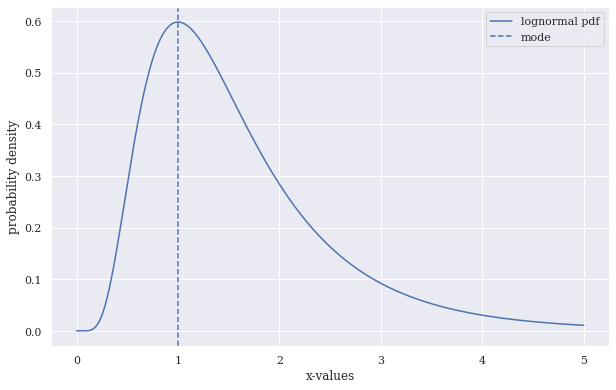

In [62]:
mode, sigma = 1, 1
lower, upper = 0, 5
mu_N, sigma_N = lognorm_params(mode, sigma)

x = np.linspace(lower, upper, 1000)
y = lognorm_pdf(x, mu_N, sigma_N)

sns.lineplot(x, y, label="lognormal pdf")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.legend()
plt.show()

Plot just the left-of-mode portion.

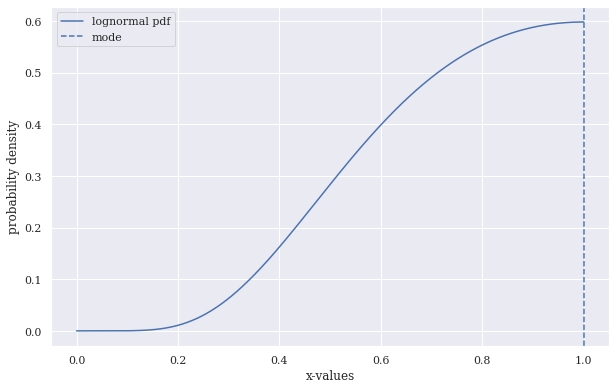

In [63]:
mode, sigma = 1, 1
mu_N, sigma_N = lognorm_params(mode, sigma)

x = np.linspace(lower, mode, 1000)
y = lognorm_pdf(x, mu_N, sigma_N)

sns.lineplot(x, y, label="lognormal pdf")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.legend()
plt.show()

Assign, for example, an upper bound of 5. Plot the left-of-mode portion of a lognormal pdf with $m = upper - mode$ and reversed $x$ values. This is the right-of-mode portion of a new bounded lognormal pdf.

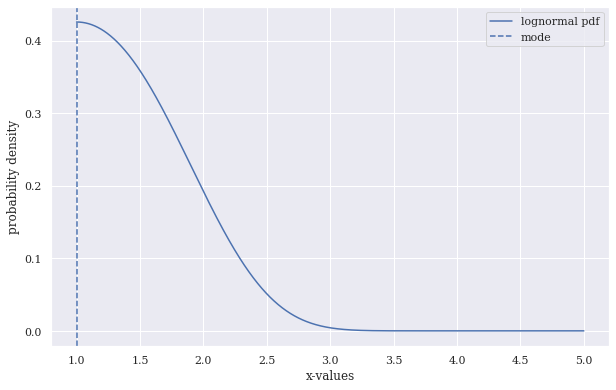

In [64]:
mode, sigma = 1, 1
lower, upper = 0, 5
mu_N, sigma_N = lognorm_params(upper - mode, sigma)

x = np.linspace(mode, upper, 1000)
y = lognorm_pdf(upper - x, mu_N, sigma_N)
sns.lineplot(x, y, label="lognormal pdf")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.legend()
plt.show()

Concatenate the left-of-mode and right-of-mode curves above. Notice that they are discontinuous at the mode.

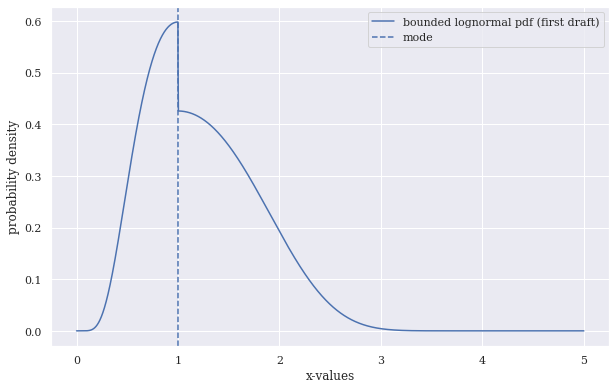

In [65]:
mu_N, sigma_N = lognorm_params(mode, sigma)
x_left = np.linspace(lower, mode, 1000)
y_left = lognorm_pdf(x_left, mu_N, sigma_N)

mu_N, sigma_N = lognorm_params(upper - mode, sigma)
x_right = np.linspace(mode, upper, 1000)
y_right = lognorm_pdf(upper - x_right, mu_N, sigma_N)

x = np.concatenate([x_left, x_right])
y = np.concatenate([y_left, y_right])
sns.lineplot(x, y, label="bounded lognormal pdf (first draft)")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.legend()
plt.show()

Scale right side so that left and right sides are continuous at the mode.

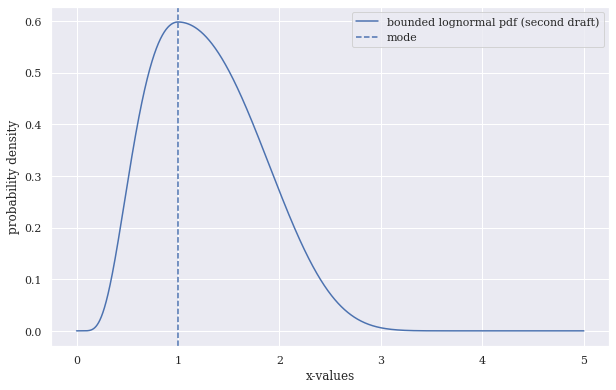

In [66]:
mu_N, sigma_N = lognorm_params(mode, sigma)
x_left = np.linspace(lower, mode, 1000)
x_left = np.append(x_left, [mode], axis=0)
y_left = lognorm_pdf(x_left, mu_N, sigma_N)

mu_N, sigma_N = lognorm_params(upper - mode, sigma)
x_right = np.linspace(mode, upper, 1000)
x_right = np.append(x_right, [mode], axis=0)
y_right = lognorm_pdf(upper - x_right, mu_N, sigma_N)

right_scale =  y_left[-1] / y_right[-1]

y_right = y_right * right_scale

x = np.concatenate([x_left[:-1], x_right[:-1]])
y = np.concatenate([y_left[:-1], y_right[:-1]])
sns.lineplot(x, y, label="bounded lognormal pdf (second draft)")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.legend()
plt.show()

What remains in order to use this as a probability density function is to scale the entire curve, so the area under the curve = 1.

### Example Usage

#### Function Plots and Random Number Generation

Probability density functions (pdf) with various modes, sigmas, and boundaries.

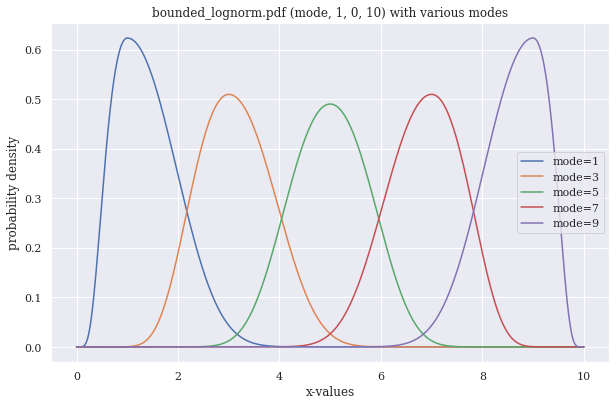

In [67]:
modes = [1, 3, 5, 7, 9]
sigma = 1
lower, upper = 0, 10
x = np.linspace(lower, upper, 1000)
for mode in modes:
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x, y, label='mode=' + str(mode))
title = 'bounded_lognorm.pdf (mode, {}, {}, {}) with various modes'
title = title.format(sigma, lower, upper)
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.title(title)
plt.show()

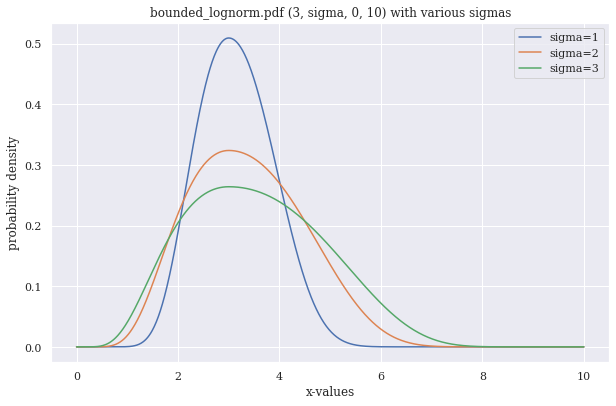

In [68]:
mode = 3
sigmas = [1, 2, 3]
lower, upper = 0, 10
x = np.linspace(lower, upper, 1000)
for sigma in sigmas:
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x, y, label='sigma=' + str(sigma))
title = 'bounded_lognorm.pdf ({}, sigma, {}, {}) with various sigmas'
title = title.format(mode, lower, upper)
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.title(title)
plt.show()

Probability density function (pdf) with 95% confidence interval

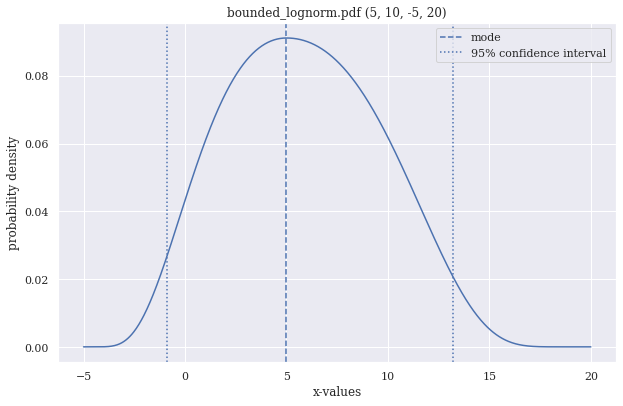

In [97]:
mode, sigma = 5, 10
lower, upper = -5, 20

x = np.linspace(lower, upper, 1000)
y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
sns.lineplot(x, y)
plt.axvline(mode, ymin=0, linestyle='dashed', label='mode')

interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
plt.axvline(interval[0], ymin=0, linestyle='dotted', 
            label='95% confidence interval')
plt.axvline(interval[1], ymin=0, linestyle='dotted')
title = title = 'bounded_lognorm.pdf ({}, {}, {}, {})'
title = title.format(mode, sigma, lower, upper)
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.title(title)
plt.legend()
plt.show()

In [ ]:
%timeit -r 3 -n 10 bounded_lognorm.pdf(x, mode, sigma, lower, upper)

The slowest run took 4.01 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 404 µs per loop


Cumulative distribution function (cdf)

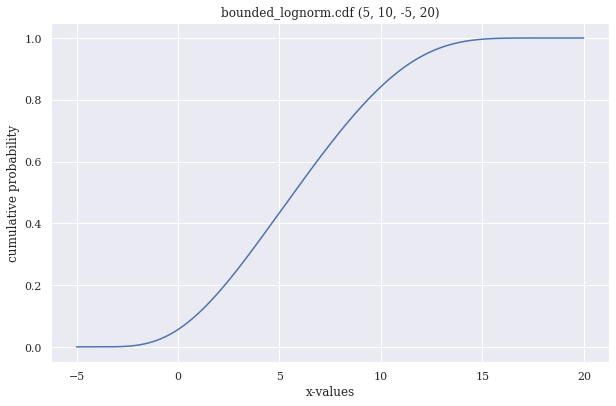

In [99]:
x = np.linspace(lower, upper, 1000)
y = bounded_lognorm.cdf(x, mode, sigma, lower, upper)
sns.lineplot(x, y)
title = title = 'bounded_lognorm.cdf ({}, {}, {}, {})'
title = title.format(mode, sigma, lower, upper)
plt.xlabel("x-values")
plt.ylabel("cumulative probability")
plt.title(title)
plt.show()

Percent point function (ppf), also known as the quantile function, is the inverse of the cdf.

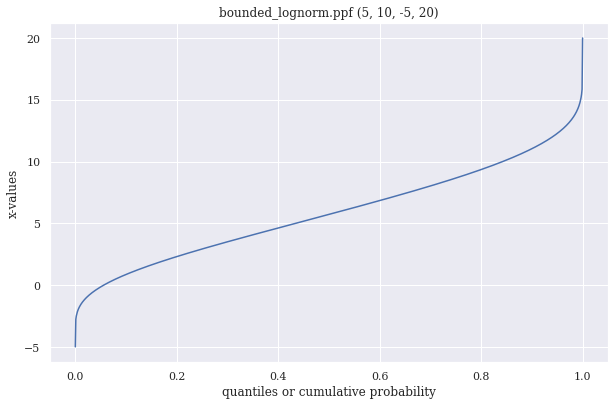

In [100]:
x = np.linspace(0, 1, 1000)
y = bounded_lognorm.ppf(x, mode, sigma, lower, upper)
sns.lineplot(x, y)
title = title = 'bounded_lognorm.ppf ({}, {}, {}, {})'
title = title.format(mode, sigma, lower, upper)
plt.xlabel("quantiles or cumulative probability")
plt.ylabel("x-values")
plt.title(title)
plt.show()

In [ ]:
%timeit -r 3 -n 10 bounded_lognorm.ppf(x, mode, sigma, lower, upper)

10 loops, best of 3: 605 µs per loop


Print 10 random numbers from this distribution.

In [ ]:
bounded_lognorm.rvs(mode, sigma, lower, upper, size=10)

array([ 4.75829201, -0.29076434,  4.64563993,  2.1850653 ,  3.87943706,
        7.92957866,  5.38912014,  6.45925499,  6.18434663,  5.60280359])

Plot a histogram of 10,000 random numbers from this distribution.

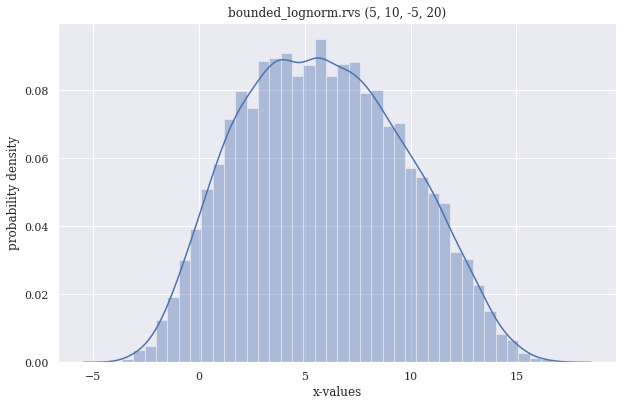

In [72]:
y = bounded_lognorm.rvs(mode, sigma, lower, upper, size=10000)
sns.distplot(y)
title = title = 'bounded_lognorm.rvs ({}, {}, {}, {})'
title = title.format(mode, sigma, lower, upper)
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.title(title)
plt.show()

#### Summary Statistics

Median

In [ ]:
bounded_lognorm.median(mode, sigma, lower, upper)

array([5.72045173])

Mean

In [ ]:
bounded_lognorm.mean(mode, sigma, lower, upper)

array([5.84940913])

Standard deviation

In [ ]:
bounded_lognorm.std(mode, sigma, lower, upper)

array([3.811695])

Note that this is *not* the same as $\sigma$, due to the proximity of the lower and upper domain boundaries. See the section below comparing the bounded lognormal and normal distributions for an illustration.

Moments

In [ ]:
mean, var, skew, kurt = bounded_lognorm.stats(mode, sigma, lower, upper, 
                                              moments='mvsk')
mean, var, skew, kurt 

(array([5.84940913]),
 array([14.5290188]),
 array([0.13655252]),
 array([-0.66320023]))

In [ ]:
bounded_lognorm.moment(1, mode, sigma, lower, upper)

array([5.84940913])

Differntial Entropy


In [ ]:
bounded_lognorm.entropy(mode, sigma, lower, upper) 

array([2.74403487])

#### Fitting Curves to Data

See for reference
* https://www.mathworks.com/help/stats/examples/fitting-a-univariate-distribution-using-cumulative-probabilities.html
* https://math.stackexchange.com/questions/2365267/pdf-vs-cdf-fitting
* http://www.mathwave.com/articles/distribution-fitting-graphs.html

Create some noisy random numbers and fit them to a bounded_lognorm.pdf using non-linear least squares.

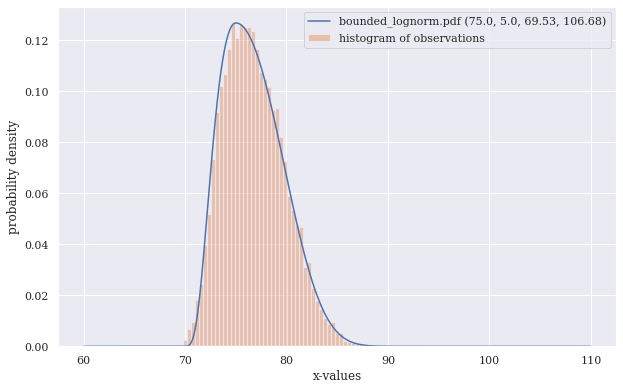

In [73]:
sample_size = 10000
data = bounded_lognorm.rvs(75, 5, 70, 100, size=sample_size)
data += 1 * np.random.normal(0, 1, size=sample_size) # add some noise

# Here, fmode=75 and fsigma=5 mean fix the params mode and sigma to 75 and 5,
# respectively, and estimate the other params.
shapes, results = bounded_lognorm.fit(data, MLE=False, verbose=True,
                                      fmode=75, fsigma=5)

shapes_rounded = tuple(shapes.round(2))
label = ('bounded_lognorm.pdf ' + str(shapes_rounded)) 

xdata = np.linspace(60, 110, sample_size)
sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.distplot(data, kde=False, norm_hist=True, 
             label="histogram of observations")
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.legend(loc='upper right')
plt.show()

Covariance matrix of estimated parameters, in this case `lower` and `upper`

In [ ]:
pcov = results[1]
pcov

array([[ 9.71644789e-06, -6.39461264e-05],
       [-6.39461264e-05,  9.70694010e-04]])

Standard deviation of estimated parameters, in this case `lower` and `upper`

In [ ]:
np.sqrt(np.diag(pcov))

array([0.00311712, 0.03115596])

Fit the same random numbers to a bounded_lognorm.pdf using maximum likelihood estimation.

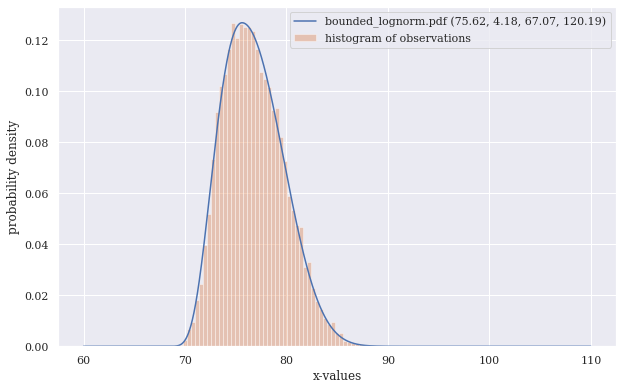

In [74]:
# Here, gmode=75 and gsigma=5 mean provide initial guesses of 75 and 5 to  
# mode and sigma, respectively. All parameters here are estimated.
shapes = bounded_lognorm.fit(data, MLE=True, verbose=False,
                             gmode=75, gsigma=5)

shapes_rounded = tuple(shapes.round(2))
label = ('bounded_lognorm.pdf ' + str(shapes_rounded)) 

xdata = np.linspace(60, 110, sample_size)
sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.distplot(data, kde=False, norm_hist=True, 
             label="histogram of observations")
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.legend(loc='upper right')
plt.show()

### The `sigma` Parameter and Standard Deviation

#### Introduction

Say, in order to simulate an apartment complex, you need an array of random occupancies, with a range 0 to 100 percent, a mode of 90 percent, and sigma of 5 percent. What is the sample standard deviation of that array?

In [76]:
occs_params = 90, 5, 0, 100
occs = bounded_lognorm.rvs(*occs_params, size=10000)
occs_sample_std = np.std(occs)
occs_sample_std

3.7383072047325476

Which is very close to the population standard deviation.

In [77]:
occs_std = bounded_lognorm.std(*occs_params)
occs_std

array([3.70519447])

Notice however that this is not the same as sigma, because the dispersion is compressed by the lower and upper bounds. What sigma then should you specify, given observed occupancies having a standard deviation of 3.7 percent? 

You could estimated it with the `fit` function.

In [ ]:
occs_params_estd = bounded_lognorm.fit(occs, flower=0, fupper=100)
occs_params_estd

array([ 89.99050738,   5.01581471,   0.        , 100.        ])

In [ ]:
bounded_lognorm.std(*occs_params_estd)

array([3.71730416])

#### Visualizing the Problem

Here is a comparison of random variates having a standard deviation of 5 vs those with a sigma of 5.

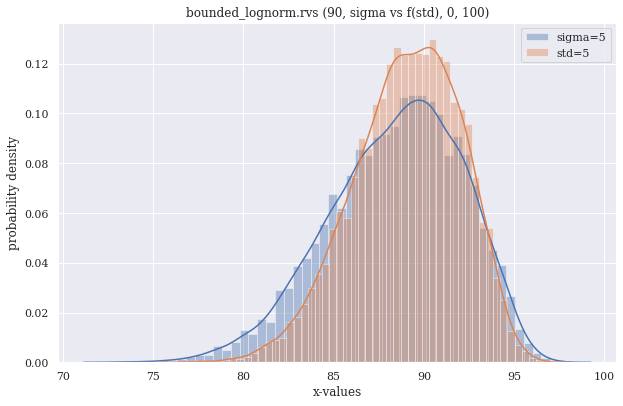

In [78]:
rvs_1 = bounded_lognorm.rvs(*occs_params, size=10000)
sns.distplot(rvs_1, norm_hist=True, label='sigma=' + str(occs_params[1]))

occs_params_2 = occs_params[0], occs_std, occs_params[2], occs_params[3]
rvs_2 = bounded_lognorm.rvs(*occs_params_2, size=10000)
sns.distplot(rvs_2, norm_hist=True, label='std=' + str(occs_params[1]))

title = title = 'bounded_lognorm.rvs ({}, sigma vs f(std), {}, {})'
title = title.format(occs_params[0], occs_params[2], occs_params[3])
plt.title(title)
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.legend()   
plt.show() 

Here is one way to visualize how encroachment of a boundary compressess dispersion. As the upper bound gets closer to the mode, the distribution is more peaked and the right shoulder is pushed in, toward the mode.

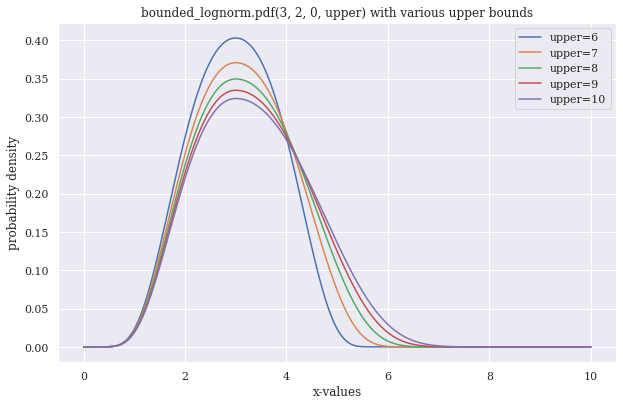

In [79]:
mode, sigma, lower = 3, 2, 0
uppers = [6, 7, 8, 9, 10]
x = np.linspace(lower, uppers[-1], 1000)

for upper in uppers:
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x, y, label='upper=' + str(upper))

title = 'bounded_lognorm.pdf({}, {}, {}, upper) with various upper bounds'
title = title.format(mode, sigma, lower)
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.title(title)
plt.show()

What if we hold the bounds constant but increase sigma?

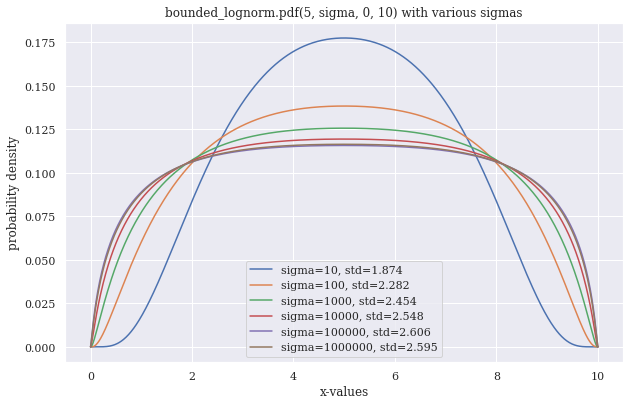

In [80]:
mode = 5
powers = np.array([1, 2, 3, 4, 5, 6])
sigmas = 10**powers
lower, upper = 0, 10
x = np.linspace(lower, upper, 1000)
for sigma in sigmas:
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    std = bounded_lognorm.std(mode, sigma, lower, upper)[0]
    label = 'sigma=' + str(sigma) + ', std=' +str(round(std, 3))
    sns.lineplot(x, y, label=label)
title = 'bounded_lognorm.pdf({}, sigma, {}, {}) with various sigmas'
title = title.format(mode, lower, upper)
plt.xlabel("x-values")
plt.ylabel("probability density")
plt.title(title)
plt.show()

Notice that even as sigma increases at an exponential rate, standard deviation increases at a declining rate. This suggests an upper limit to standard deviation in the presence of domain boundaries. Because the pdfs above appear increasingly rectangular, a plausible candidate for that limit is the standard deviation of the [continuous uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution):

$$
\sigma_U = \sqrt{(upper - lower)^2/12} 
$$

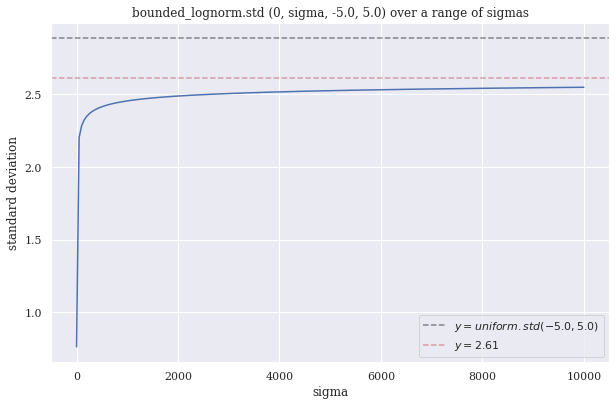

In [ ]:
sigma_min, sigma_max = 1, 1e4
sigmas = np.linspace(sigma_min, sigma_max, 200)
width = 1e1  # support width = upper - lower
guess = round(0.261 * width, 3)
w  = 0.5  # location of mode relative to support width
lower, upper = -width * w, width * (1 - w)

stds = []
for sigma in sigmas:
    std = bounded_lognorm.std(0, sigma, lower, upper)[0]
    stds.append(std)

sns.lineplot(sigmas, stds)

uniform_std = np.sqrt((upper - lower)**2 / 12)
hline_label = r'$y = uniform.std({{{}}}, {{{}}})$'.format(lower, upper)
plt.axhline(uniform_std, c='k', alpha=0.5, ls='--', label=hline_label)

hline_label2 = r'$y = {{{}}}$'.format(guess)
plt.axhline(guess, c='r', alpha=0.5, ls='--', label=hline_label2)

title = 'bounded_lognorm.std (0, sigma, {}, {}) over a range of sigmas'
title = title.format(lower, upper)
plt.title(title)
plt.xlabel('sigma')
plt.ylabel('standard deviation')
plt.legend()
plt.show()

Say you have a symmetical bounded lognormal distribution. How does the standard deviation change as the boundaries move farther apart?

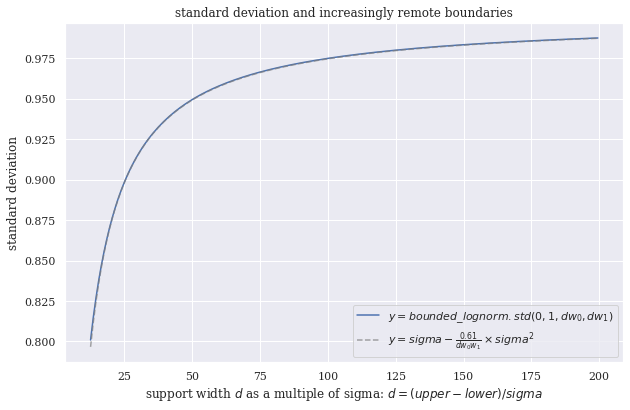

In [ ]:
def std_rough_estimator(mode, sigma, lower, upper, adj=0.61):    
    d = upper - lower
    w = (mode - lower) / d  # weight of left-of-mode support
    a = d * w * (1 - w) 
    std_hat = sigma - (adj / a) * sigma**2
    return std_hat

mode, sigma = 0, 1
adj = 0.61 
w = 0.4
w = min(w, 1 - w)
min_x = sigma * 5/w

xs = np.arange(min_x, 200)
ys1, ys2 = [], []
for x in xs:
   
    lower, upper = -w * x , (1 - w) * x 
    stdev = bounded_lognorm.std(mode, sigma, lower, upper)[0]
    ys1.append(stdev)
    
    stdev2 = std_rough_estimator(mode, sigma, lower, upper, adj)
    ys2.append(stdev2)

bounds_label = str(sigma) + 'd'
bounds_label = 'd' if sigma == 1 else bounds_label

line_label = r'$y = bounded\_lognorm.std({{{}}},{{{}}}, {{{}}}w_0, {{{}}}w_1)$'
line_label = line_label.format(mode, sigma, bounds_label, bounds_label)
sns.lineplot(xs, ys1, label=line_label)

line_label2 = r'$y = sigma - \frac{{{}}}{{{}w_0 w_1}} \times sigma^2$'
line_label2 = line_label2.format(adj, bounds_label)
sns.lineplot(xs, ys2, 
             label= line_label2, color='gray', alpha=0.7, linestyle='--')

plt.title('standard deviation and increasingly remote boundaries')
plt.xlabel(r'support width $d$ as a multiple of sigma: ' 
           + '$d = (upper - lower)/sigma$')
plt.ylabel('standard deviation')
plt.legend()
plt.show()

As the boundaries are pushed farther away from the mode, the standard deviation approaches sigma. The dashed line is a quadratic approximation.

#### Estimating Sigma, First Pass

Rearranging the above quadratic approximation to solve for sigma and generalizing results in `sigma_from_std_rough()` below, which (very) roughly estimates sigma from standard deviation.

Here is set of routines for exploring this and other sigma_hat functions in this section:

*   `sigma_hat_check()` checks the accuracy of estimated sigma (sigma_hat), 
*   `sigma_hat_plot()` plots the accuracy of sigma_hat, and  
*   `rvs_from_std(mode, std, lower, upper, func)` creates an array of random variates. 

In [ ]:
def sigma_from_std_rough(mode, std, lower, upper, b=[1.5, 3, 1.5]):
    d = upper - lower
    w = (mode - lower) / d
    std_to_short_leg_ratio = std / min(upper - mode, mode - lower)
    adj = std_to_short_leg_ratio**b[0] * b[1] + b[2]
    a =  d * w * (1 - w) * adj
    sigma_hat = a / 2 - np.sqrt((a / 2)**2 - std * a)  
    return sigma_hat    

def rvs_from_std(mode, std, lower, upper, size=1, func=None, **kwargs):
    with np.errstate(divide='ignore', invalid='ignore'):
        if func is None:
            sigma_hat = std
        else:
            sigma_hat = func(mode, std, lower, upper, **kwargs)
    return bounded_lognorm.rvs(mode, sigma_hat, lower, upper, size=size)

def sigma_hat_check(mode, std, lower, upper, func=None, **kwargs):
    with np.errstate(divide='ignore', invalid='ignore'):
        if func is None:
            sigma_hat = std
        else:
            sigma_hat = func(mode, std, lower, upper, **kwargs) 
        std_hat = bounded_lognorm.std(mode, sigma_hat, lower, upper)
    result = std_hat / std - 1
    return result[0]

def sigma_hat_plot(mode, std, lower, upper, variable_param='mode',
                   func=None, n=100, tol=0.01,
                   label=None, vline=None, **kwargs):
    support = bounded_lognorm.support(mode, std, lower, upper)
    ys = []
    if variable_param=='mode':
        title_mode_and_std = 'mode, f(' + str(std) + ')'
        param_vals = np.linspace(support[0] + tol, support[1] - tol, n) 
        for param_val in param_vals:
            mode = param_val
            y = sigma_hat_check(mode, std, lower, upper, func, **kwargs)
            ys.append(y)
    else:  # variable_param=='std':
        title_mode_and_std = str(mode) + ', f(std)' 
        param_vals = np.linspace(0 + tol, support[1] - support[0], n)
        for param_val in param_vals:
            std = param_val
            y = sigma_hat_check(mode, std, lower, upper, func, **kwargs)
            ys.append(y)
    if vline: 
        vline_label = str(vline * 100) + '% line'
        plt.axvline(vline * (support[1] - support[0]), 
                    c='k', alpha=0.5, ls='--', label=vline_label)
    if label is None: 
        label = 'f: sigma_hat = std' if func is None else func.__name__
    sns.lineplot(param_vals, ys, label=label)
    title = 'bounded_lognorm ({}, {}, {}) over a range of {}s'
    title = title.format(title_mode_and_std, lower, upper, variable_param)
    plt.title(title)
    plt.xlabel(variable_param)
    plt.ylabel('std_hat / std - 1')
    plt.legend()       

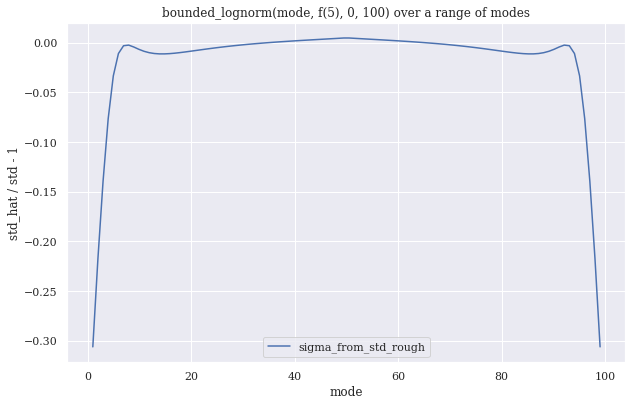

In [ ]:
sigma_hat_plot(*occs_params, 'mode', sigma_from_std_rough, tol=1)

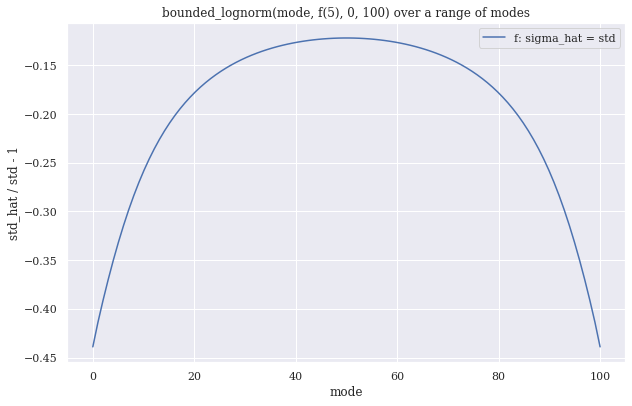

In [ ]:
sigma_hat_plot(*occs_params, 'mode')

In [ ]:
def sigma_from_std_rough_minfunc(b):
    mode_min = 0.01
    modes = np.linspace(mode_min, 0.5 - mode_min, 100)
    std, lower, upper = mode_min, 0, 1
    SE = []
    for mode in modes:
        sigma_hat = sigma_from_std_rough(mode, std, lower, upper, b)
        std_hat = bounded_lognorm.std(mode, sigma_hat, lower, upper)[0]
        SE.append((std_hat - std)**2)  
    SSE = np.sum(SE)  # sum of squared errors
    return SSE

minimize(sigma_from_std_rough_minfunc, [1.5, 3, 1.5], 
         method='Nelder-Mead', tol=1e-2)

 final_simplex: (array([[1.5343009 , 2.98124625, 1.57766436],
       [1.53631336, 2.97349912, 1.58098549],
       [1.52639808, 2.97532972, 1.57702433],
       [1.53032172, 2.97393319, 1.57600444]]), array([4.28248250e-08, 4.28792443e-08, 4.28802719e-08, 4.29189408e-08]))
           fun: 4.282482503630931e-08
       message: 'Optimization terminated successfully.'
          nfev: 37
           nit: 20
        status: 0
       success: True
             x: array([1.5343009 , 2.98124625, 1.57766436])

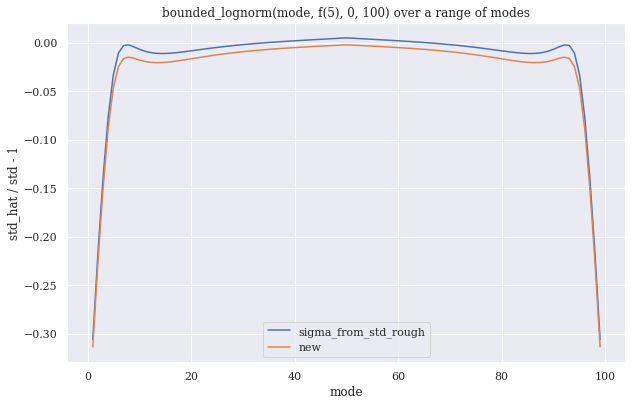

In [ ]:
sigma_hat_plot(*occs_params, 'mode', sigma_from_std_rough, tol=1)
sigma_hat_plot(*occs_params, 'mode', 
               sigma_from_std_rough, b=[1.5343009 , 2.98124625, 1.57766436],
               tol=1, label='new')

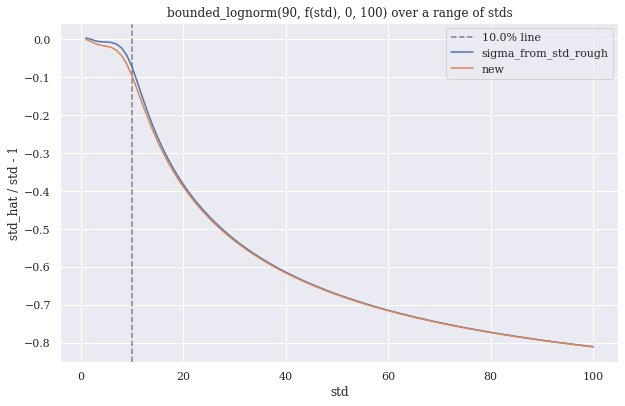

In [ ]:
sigma_hat_plot(*occs_params, 'std', sigma_from_std_rough, tol=1, vline=0.1)
sigma_hat_plot(*occs_params, 'std', 
               sigma_from_std_rough, b=[1.5343009 , 2.98124625, 1.57766436],
               tol=1, label='new')

In [ ]:
%timeit -r 3 -n 10 sigma_from_std_rough(*occs_params)

10 loops, best of 3: 2.03 µs per loop


#### Estimating Sigma Using Interpolation

You could also use interpolation to invert the `std` function. Here is set of routines for exploring this technique:

*   `sigma_from_std()` uses polynomial or spline interpolation to estimate sigma from standard deviation, 
*   `sigma_from_std_check()` checks the accuracy of `sigma_from_std()`, 
*   `rvs_from_std(mode, std, lower, upper)` creates an array of random variates, and 
*   `sigma_plot()` plots interpolation accuracy.  



In [ ]:
from scipy.interpolate import make_interp_spline

In [ ]:
def sigma_from_std_interp(mode, std, lower, upper, 
                          kind='poly', z=1, n_per_z=10, order=5):
    sigmas = np.linspace(std, std * (z + 1), n_per_z * z, endpoint=True) 
    stds = []
    for sigma in sigmas:
        std_ = bounded_lognorm.std(mode, sigma, lower, upper)[0]
        stds.append(std_)
    if kind=='poly':
        f = interp1d(stds, sigmas, axis=0, kind=order, 
                     fill_value="extrapolate", assume_sorted=True)
    elif kind=='spline':
        f = make_interp_spline(stds, sigmas)
    return np.float(f(std))         

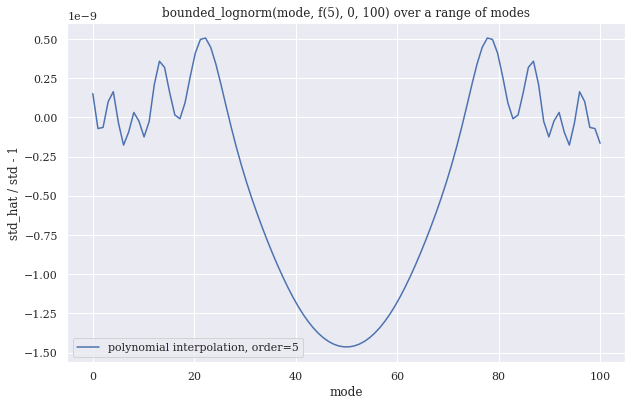

In [ ]:
sigma_hat_plot(*occs_params, 'mode',
               sigma_from_std_interp, kind='poly', z=1, n_per_z=10, order=5,
               label='polynomial interpolation, order=5')

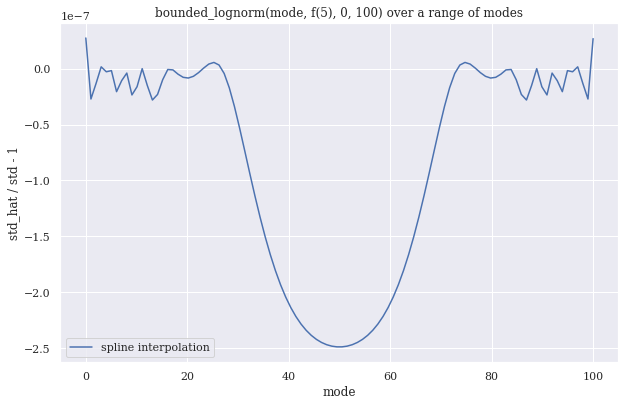

In [ ]:
sigma_hat_plot(*occs_params, 'mode',
               sigma_from_std_interp, kind='spline',
               label='spline interpolation')

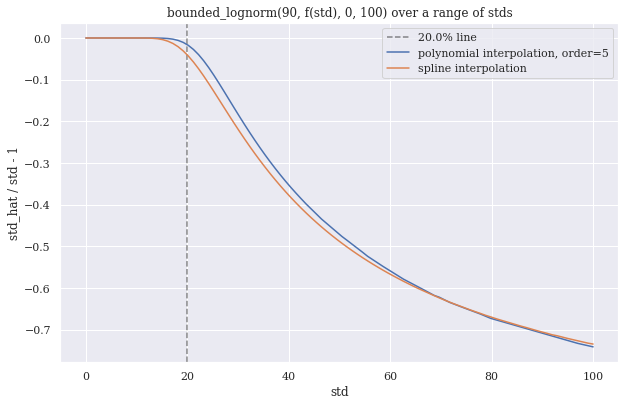

In [ ]:
sigma_hat_plot(*occs_params, 'std', 
               sigma_from_std_interp,  kind='poly', order=5,
               label='polynomial interpolation, order=5', vline=0.2)
sigma_hat_plot(*occs_params, 'std', 
               sigma_from_std_interp, kind='spline',
               label='spline interpolation')

In [ ]:
%timeit -r 3 -n 10 sigma_from_std_interp(*occs_params, kind='poly', order=5)

10 loops, best of 3: 9.89 ms per loop


In [ ]:
%timeit -r 3 -n 10 sigma_from_std_interp(*occs_params, kind='spline')

10 loops, best of 3: 10.7 ms per loop


#### Estimating Sigma Using Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
def sigma_from_std_reg_model(n=1000, order=3, max_std=None):
    lower, upper = 0, 1  # standard params
    mode = np.random.rand(n).reshape((-1, 1)) * 0.5
    
    if max_std is None:
        max_std = np.sqrt((upper - lower)**2 / 12)  # uniform_std
    sigma = np.random.rand(n).reshape((-1, 1)) * max_std

    bln = bounded_lognorm
    std = [bln.std(mode[i], sigma[i], lower, upper) for i in range(n)]
    std = np.array(std).reshape((-1, 1)) 

    poly_features = PolynomialFeatures(degree=order, include_bias=True)
    x = np.concatenate((mode, std), axis=1)
    x_ = poly_features.fit_transform(x)
    
    model = LinearRegression().fit(x_, sigma)
    b = model.coef_[0]
    p = poly_features.powers_
    r_squared = model.score(x_, sigma)
    def pred(mode, std):
        x_new = np.array([mode, std]).reshape((-1, 2))
        x_new_ = poly_features.fit_transform(x_new)
        return model.predict(x_new_)
    
    return b, p, r_squared, pred

reg_results_3  = sigma_from_std_reg_model(order=3)
reg_results_5  = sigma_from_std_reg_model(order=5)
reg_results_7  = sigma_from_std_reg_model(order=7)

def sigma_from_std_reg(mode, std, lower, upper, model=reg_results_5): 
    b, p, r_squared, pred = model
    n = len(p)
    d = upper - lower  # support width
    mode = min(mode - lower, upper - mode) / d  # standardized mode
    std = std / d  #standardized std
    sigma_hat = [b[i] * mode**p[i][0] * std**p[i][1] for i in range(n)]
    sigma_hat = sum(sigma_hat) * d  
    return sigma_hat

def sigma_from_std_reg_frozen(mode, std, lower, upper): 

    # coefficient array
    b = np.array(
        [
          7.35913468e-04, -6.85643021e-02,  1.39548813e+00,  1.16759238e+00,
         -7.94963163e+00,  1.77720351e+01, -7.45227729e+00,  2.89213925e+01,
          4.52089294e+01, -2.61971162e+02,  2.39845776e+01,  2.02425839e+01,
         -7.04588169e+02,  7.22322874e+02,  2.74700093e+03, -4.61101372e+01,
         -1.86125725e+02,  1.28791179e+03,  3.07195219e+03, -9.92149042e+03,
         -1.15662245e+04,  5.61056546e+01,  1.04506156e+02,  7.71728997e+02,
         -1.25223594e+04,  1.21820089e+04,  2.77459090e+04,  1.80568427e+04,
         -3.35723357e+01,  1.39393470e+02, -2.20022290e+03,  1.03078885e+04,
          1.01268568e+03, -3.00878429e+04, -1.52112686e+04,  5.36338085e+04
        ])
    
    # powers array
    p = np.array(
        [
         [0, 0], 
         [1, 0], [0, 1], 
         [2, 0], [1, 1], [0, 2], 
         [3, 0], [2, 1], [1, 2], [0, 3], 
         [4, 0], [3, 1], [2, 2], [1, 3], [0, 4],
         [5, 0], [4, 1], [3, 2], [2, 3], [1, 4], [0, 5],
         [6, 0], [5, 1], [4, 2], [3, 3], [2, 4], [1, 5], [0, 6],
         [7, 0], [6, 1], [5, 2], [4, 3], [3, 4], [2, 5], [1, 6], [0, 7]
        ])
    
    n = len(p)
    d = upper - lower  # support width
    mode = min(mode - lower, upper - mode) / d  # standardized mode
    std = std / d  #standardized std
    sigma_hat = [b[i] * mode**p[i][0] * std**p[i][1] for i in range(n)]
    sigma_hat = sum(sigma_hat) * d 
    return sigma_hat 

In [ ]:
b, p, r_squared, pred = reg_results_7
r_squared

0.9999989784966997

In [ ]:
sigma_from_std_reg(*occs_params)

7.331135308637765

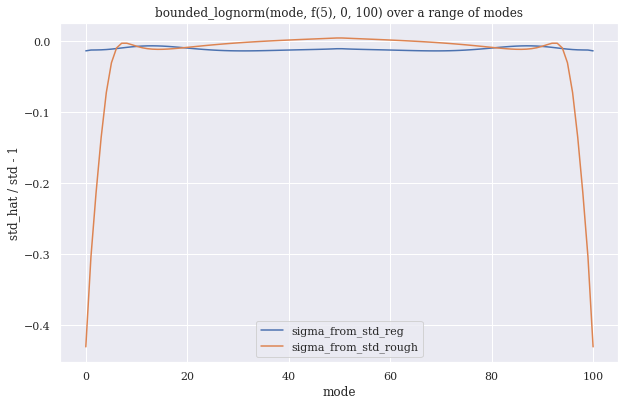

In [ ]:
sigma_hat_plot(*occs_params, 'mode', sigma_from_std_reg)
sigma_hat_plot(*occs_params, 'mode', sigma_from_std_rough)

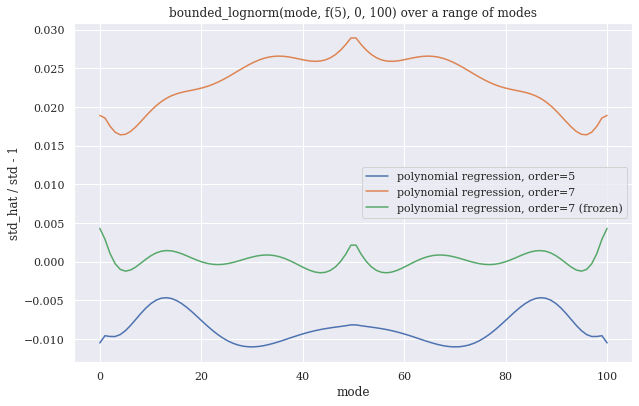

In [ ]:
sigma_hat_plot(*occs_params, 'mode', sigma_from_std_reg, model=reg_results_5,
               label='polynomial regression, order=5')
sigma_hat_plot(*occs_params, 'mode', sigma_from_std_reg, model=reg_results_7,
               label='polynomial regression, order=7')
sigma_hat_plot(*occs_params, 'mode', sigma_from_std_reg_frozen,
               label='polynomial regression, order=7 (frozen)')

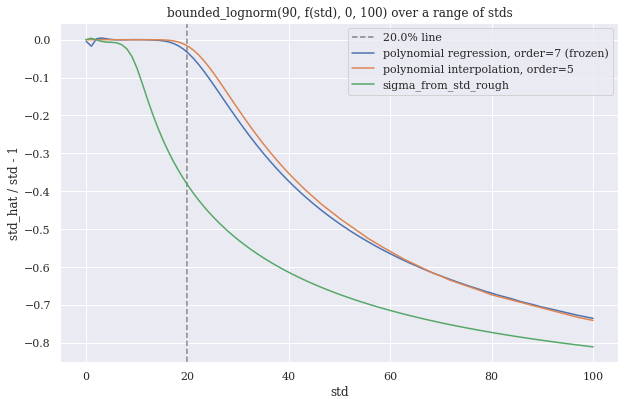

In [ ]:
sigma_hat_plot(*occs_params, 'std', sigma_from_std_reg_frozen,
               label='polynomial regression, order=7 (frozen)', 
               tol=0.1, vline=0.2)
sigma_hat_plot(*occs_params, 'std', 
               sigma_from_std_interp,  kind='poly', order=5,
               label='polynomial interpolation, order=5')
sigma_hat_plot(*occs_params, 'std', sigma_from_std_rough)

In [ ]:
%timeit -r 3 -n 10 sigma_from_std_reg(*occs_params)

10 loops, best of 3: 134 µs per loop


In [ ]:
%timeit -r 3 -n 10 sigma_from_std_reg_frozen(*occs_params)

10 loops, best of 3: 294 µs per loop


### Inflection Points and Inflection Triangles

Similar to [Wise (1952)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9574.1966.tb00496.x), here are functions to plot a pdf, its associated inflection triangle, and the relevant points. See also:
* https://www.randomservices.org/random/special/LogNormal.html
* https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9574.1966.tb00496.x
* https://stackoverflow.com/questions/49635428/tangent-to-curve-interpolated-from-discrete-data
* https://www.researchgate.net/figure/Global-characteristics-of-a-lognormal-curve-used-by-the-Wise-method-tangents-at-the_fig3_220360160
* and entropy https://www.mdpi.com/1099-4300/19/2/56/htm

In [ ]:
def inflection_points(mode, sigma, lower, upper):
    def inflection(mode, sigma):
        mu_N, sigma_N = lognorm_params(mode, sigma)
        return np.exp(mu_N 
                      - 1.5 * sigma_N**2 
                      - 0.5 * sigma_N * np.sqrt(sigma_N**2 + 4))
    I0x = inflection(mode - lower, sigma) + lower
    I1x = upper - inflection(upper - mode, sigma)
    I0y, I1y = bounded_lognorm.pdf([I0x, I1x], mode, sigma, lower, upper)
    return (I0x, I0y), (I1x, I1y)

def triangle_area(A, B, C):
    area = (A[0] * (B[1] - C[1]) + 
            B[0] * (C[1] - A[1]) + 
            C[0] * (A[1] - B[1])) / 2
    return np.abs(area)

def quadrilateral_area(A, B, C, D):
    return triangle_area(A, B, C) + triangle_area(C, D, A)

def length(A, B):
    return np.sqrt((A[0] - B[0])**2 + (A[1] - B[1])**2)

def slope(A, B):
    return (A[1] - B[1]) / (A[0] - B[0])

def angle(A, B, C, degrees=False):
    a = np.arctan2(np.array([A[1] -B[1]]), np.array([A[0] -B[0]]))
    b = np.arctan2(np.array([C[1] -B[1]]), np.array([C[0] -B[0]]))
    angle = np.abs(b - a)
    if degrees:
        angle = np.rad2deg(angle)
    return angle

def intersection(A, B, C, D):
    slope0 = slope(A, B)
    slope1 = slope(C, D)
    y_intercept0 = A[1] - slope0 * A[0]
    y_intercept1 = C[1] - slope1 * C[0]
    x = -(y_intercept1 - y_intercept0) / (slope1 - slope0)
    y = slope0 * x + y_intercept0
    return x, y

def tangent_at_inflection(I, x, y):
    inflection = I[0]
    i = np.argmin(np.abs(x - inflection))
    x1 = x[i:i+2]
    y1 = y[i:i+2]
    dydx = np.diff(y1) / np.diff(x1)
    f = lambda x: dydx * x + (y1[0] - dydx * x1[0])
    slope_ = slope((x[1], f(x[1])), (x[0], f(x[0])))[0]
    y_intercept = (f(x[1]) - slope_ * x[1])[0] 
    x_intercept = -y_intercept/slope_
    return slope, x_intercept, y_intercept

def plot_point(text, xy, xyoffset, ha='left', 
               arrow=True, show_coords=True, round=3):
    plt.plot(xy[0], xy[1], marker='o', markersize=3, color="red")
    arrowprops = dict(arrowstyle='->', color='k') if arrow else None
    if show_coords:
        xyr = tuple(np.array(xy).flatten().round(round))
        text = text + ":" + str(xyr)                 
    plt.annotate(text, xy=xy, xycoords='data', 
                    xytext=xyoffset, textcoords='offset points',
                    va='center', ha=ha, arrowprops=arrowprops)

def plot_segment(A, B):
    plt.plot((A[0], B[0]), (A[1], B[1]))

def plot_triangle(mode, sigma, lower, upper, 
                  plot=True, xmin=None, xmax=None, 
                  show_coords=True, round=3,
                  return_coords=False):
    
    def plot_point_(text, xy, xyoffset, ha='left', arrow=True):
        if xmin <= xy[0] <= xmax:
            plot_point(text, xy, xyoffset, ha, arrow, show_coords, round)
    
    if xmin is None: xmin = lower
    if xmax is None: xmax = upper
    x = np.linspace(xmin, xmax, 1000)
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    
    M = mode, 0
    N = mode, bounded_lognorm.pdf(mode, mode, sigma, lower, upper)[0]
    I, J = inflection_points(mode, sigma, lower, upper)
    A = tangent_at_inflection(I, x, y)[1], 0  # x-intercept of left leg
    B = tangent_at_inflection(J, x, y)[1], 0  # x-intercept of right leg
    C = intersection(A, I, B, J)  # triangle apex
    L, U = (lower, 0), (upper, 0)  # upper and lower bounds at x=0 
    
    if plot:        
        warning_category = np.VisibleDeprecationWarning
        np.warnings.filterwarnings('ignore', category=warning_category)
        sns.lineplot(x, y)
        
        plot_segment(A, C)  # left leg
        plot_segment(B, C)  # right leg
        plot_segment(A, B)  # base
        plot_segment(I, J)  # base of smaller triangle
        
        plot_point_("A", A, (-40, 20), ha='right', arrow=True)
        plot_point_("B", B, (40, 20), ha='left', arrow=True)  
        plot_point_("C", C, (10, 0), arrow=False)
        plot_point_("I", I, (-10, 0), ha='right', arrow=False)
        plot_point_("J", J, (10, 0), arrow=False)            
        plot_point_("M", M, (0, 15), ha='center', arrow=False)
        plot_point_("N", N, (40, 0), arrow=True)
        plot_point_("L", L, (-10, 0), ha='right', arrow=False)
        plot_point_("U", U, (10, 0), ha='left', arrow=False)
        
        title = ('bounded_lognorm.pdf ({}, {}, {}, {}) ' +
                 'and its associated inflection triangle')
        title = title.format(mode, sigma, lower, upper)
        plt.title(title)        
        plt.ylabel("probability density")
        plt.xlabel("x-values")
        plt.show()
    
    if return_coords:
        return A, B, C, I, J, M, N, L, U

def plot_angle_vs_dispersion(mode, lower, upper, sigma_mult=100, n=1000, 
                             plot_sigma=False, plot_degrees=False, 
                             plot_max=True):
    d = upper - lower
    sigma_range = np.array([0.1, sigma_mult]) * d
    disps, angs = [], []
    for sigma in np.linspace(sigma_range[0], sigma_range[1], n):
        params = mode, sigma, lower, upper
        specs = plot_triangle(*params, return_coords=True, plot=False)
        A, B, C, I, J, M, N, L, U = specs
        disp = sigma if plot_sigma else bounded_lognorm.std(*params)[0]
        disps.append(disp)
        ang = angle(A, C, B)[0]
        angs.append(ang)
    disps, angs = np.array(disps), np.array(angs)
    angs = np.rad2deg(angs) if plot_degrees else angs
    sns.lineplot(disps, angs)
    max_ang = max(angs) 
    disp_at_max_ang = disps[angs.argmax()]  
    if plot_max:
        xoffset = 50 if plot_sigma else 0
        plot_point('max', [disp_at_max_ang, max_ang], 
                   (xoffset, -40), ha='center')
    title = 'bounded_lognorm({}, sigma, {}, {}) over a range of sigmas'
    title = title.format(mode, lower, upper)
    plt.title(title)
    plt.ylabel("angle (degrees)" if plot_degrees else "angle (radians)")
    plt.xlabel("sigma" if plot_sigma else "standard deviation")
    plt.show()

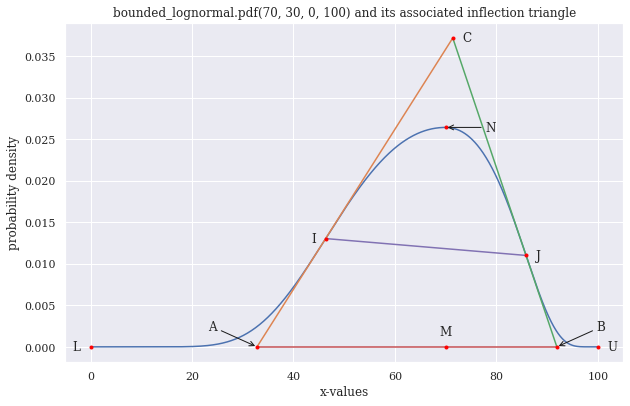

In [ ]:
mode, sigma, lower, upper = 70, 30, 0, 100
specs = plot_triangle(mode, sigma, lower, upper, xmin=None, xmax=None, 
                      return_coords=True, show_coords=False)
A, B, C, I, J, M, N, L, U = specs

In [ ]:
triangle_area(A, B, C)

1.0987508149723544

In [ ]:
triangle_area(I, J, M)

0.2334500805419762

In [ ]:
length(A, B) / length(L, U)

0.5910844448305282

In [ ]:
np.rad2deg(np.arctan(slope(C, A)))  # angle in degrees of AC

0.055193100804251494

In [ ]:
angle(A, C, B)

array([0.99911652])

How is the angle ACB related to dispersion? Is there a maximum angle and at what dispersion does it reach the maxiumum?

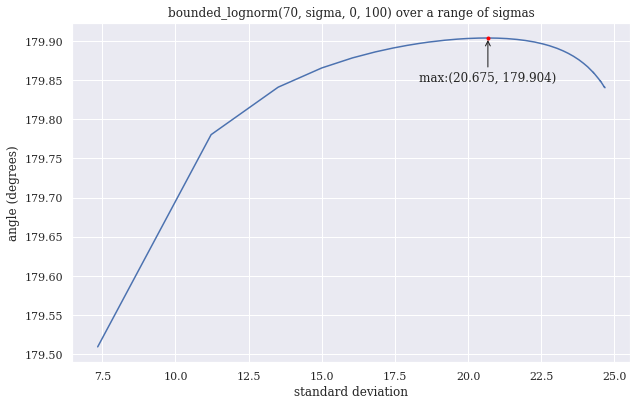

In [ ]:
plot_angle_vs_dispersion(mode, lower, upper, plot_sigma=False, plot_degrees=True)

Define a new point Q at the intersection of the lines CN and AB, and find the area of the the triangle IJQ.

In [ ]:
Q = intersection(C, N, A, B)
triangle_area(I, J, Q)

0.23695107018431688

Define a new points G and H, where maximum density intersects the tangents. Find the area of the the triangle GHM.

In [ ]:
G = intersection(A, C, N, (0, N[1]))
H = intersection(B, C, N, (0, N[1]))
triangle_area(G, H, M) * 2

0.45192201725347636

In [ ]:
quadrilateral_area(G, H, J, I)

0.4102139979910442

How do these measurements compare to the ratio standard deviation to sigma?

In [ ]:
bounded_lognorm.std(mode, sigma, lower, upper) / sigma

array([0.46361693])

### Differential Entropy
See here for problems with this measure: 
https://en.wikipedia.org/wiki/Differential_entropy

In [89]:
def entropy_plot(mode, sigma, lower, upper, 
                 variable_param='mode', n=100, tol=0.01):
    support = bounded_lognorm.support(mode, sigma, lower, upper)
    ys  = []
    if variable_param=='mode':
        param_vals = np.linspace(support[0] + tol, support[1] - tol, n)
        for param_val in param_vals:
            mode = param_val
            y = bounded_lognorm.entropy(mode, sigma, lower, upper)[0]
            ys.append(y)
        title_mid = 'mode' + ', ' + str(sigma)
    else:
        param_vals = np.linspace(0 + tol, support[1] - support[0], n)
        for param_val in param_vals:
            sigma = param_val
            y = bounded_lognorm.entropy(mode, sigma, lower, upper)[0]
            ys.append(y)
        title_mid = str(mode) + ', ' + 'sigma' 
    sns.lineplot(param_vals, ys)
    plt.xlabel(variable_param)
    plt.ylabel("differential entropy")   
    title = 'bounded_lognorm.entropy ({}, {}, {}) over a range of {}s'
    title = title.format(title_mid, lower, upper, variable_param)
    plt.title(title)
    plt.show()

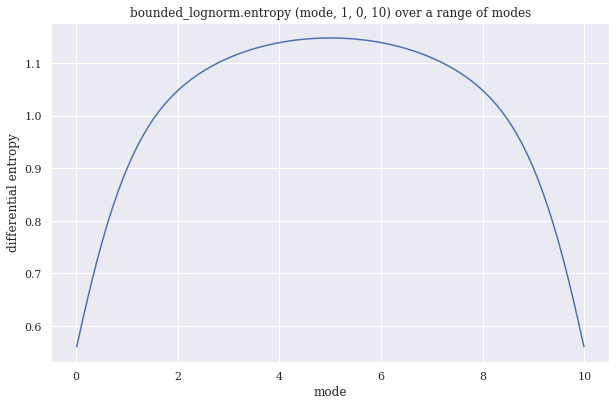

In [90]:
entropy_plot(5, 1, 0, 10, 'mode')

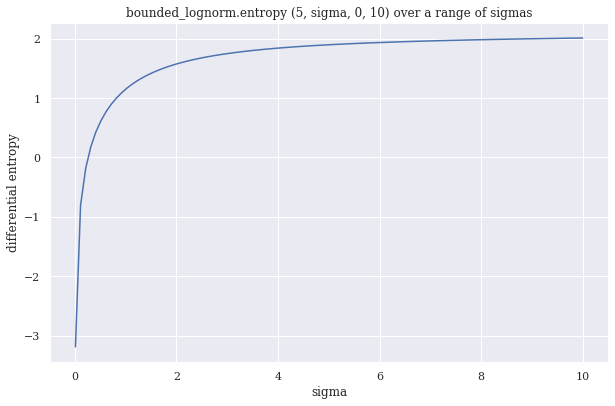

In [91]:
entropy_plot(5, 1, 0, 10, 'sigma')

### Comparing to Other Distributions

#### The Normal Distribution

Let's first define a function that plots a normal pdf and a symmetrical bounded lognormal pdf for comparison. Include the 95% confidence interval for each. A symmetrical bounded lognormal distribution is one in which the mode is the midpoint between the lower and upper boundaries. Take as a paramater `spread` or distance from the mode to the domain boundaries.

In [92]:
def compare_to_standard_N(spread):
    mode, sigma = 0, 1
    lower = mode - spread
    upper = mode + spread

    x = np.linspace(-4, 4, 1000)
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x,y, label='bounded_lognorm.pdf')
    interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
    plt.axvline(interval[0], ymin=0, linestyle='dashed', 
                label='bounded_lognorm 95% conf. interval')
    plt.axvline(interval[1], ymin=0, linestyle='dashed')

    y = norm.pdf(x, loc=mode, scale=sigma)
    sns.lineplot(x,y, label='standard normal pdf')
    interval2 = norm.interval(0.95, loc=mode, scale=sigma)
    plt.axvline(interval2[0], ymin=0, linestyle='dashed', c='red', alpha=0.5,
                label='standard normal 95% conf interval')
    plt.axvline(interval2[1], ymin=0, linestyle='dashed', c='red', alpha=0.5)

    title = ('standard normal vs bounded lognormal with bounds at '
             + r'$\pm$' + str(spread))
    plt.title(title)
    plt.xlabel("x-values")
    plt.ylabel("probability density")
    plt.legend()
    plt.show()

As the upper and lower bounds move away from the mode, the bounded lognormal pdf appears to better approximate the normal pdf.

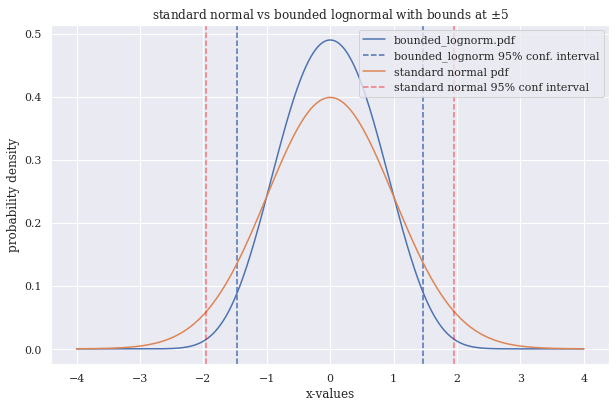

In [93]:
compare_to_standard_N(5)

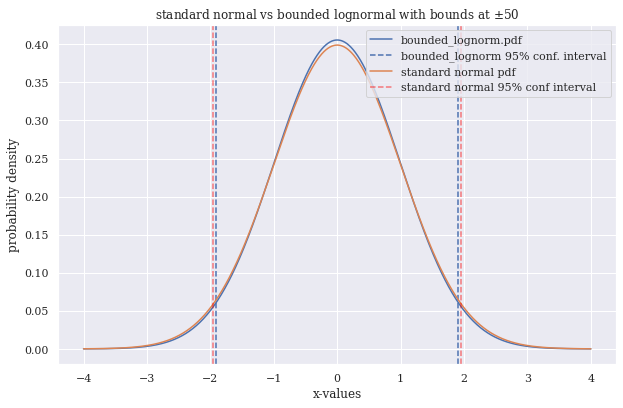

In [94]:
compare_to_standard_N(50)

So that at a large enough spread, the two pdfs are visually indistinguishable.

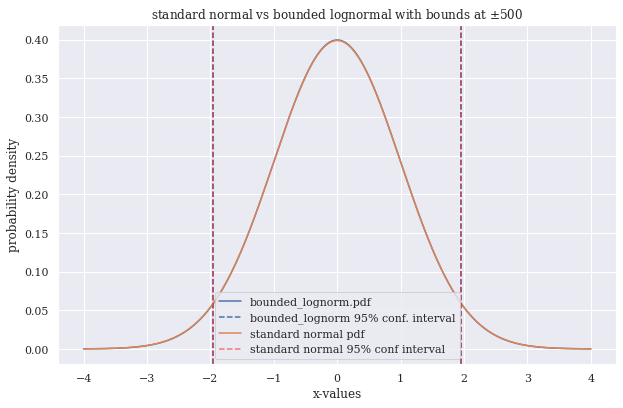

In [95]:
compare_to_standard_N(500)

Moreover, we cannot reject the null hypothesis that the `spread=500` sample comes from a normal distribution--and even less so at higher spreads.

In [ ]:
alpha = 0.05
spread = 500
mode, sigma = 0, 1
lower, upper = mode - spread, mode + spread
wide_BL_sample = bounded_lognorm.rvs(mode, sigma, lower, upper, size=100000)
_, pvalue = normaltest(wide_BL_sample)
print("pvalue = {:.3}".format(pvalue))
if pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

pvalue = 0.729
The null hypothesis cannot be rejected


And as `spread` increases, excess kurtosis approaches 0.

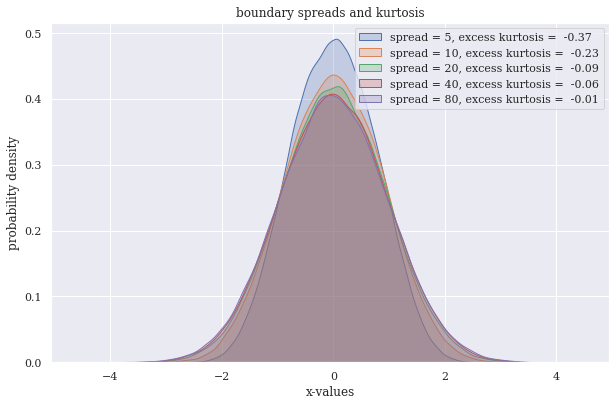

In [ ]:
mode, sigma = 0, 1
spreads = [5, 10, 20, 40, 80]
for spread in spreads:
    lower, upper = mode - spread, mode + spread
    y = bounded_lognorm.rvs(mode, sigma, lower, upper, size=100000)
    k = kurtosis(y, fisher=True)
    label = 'spread = ' + str(spread)
    label += ', excess kurtosis =  ' + str(round(k,2))
    sns.kdeplot(y, label=label, shade=True)
plt.xlabel("x-values")
plt.ylabel("probability density")
title = ('boundary spreads and kurtosis')
plt.title(title)
plt.legend()
plt.show()

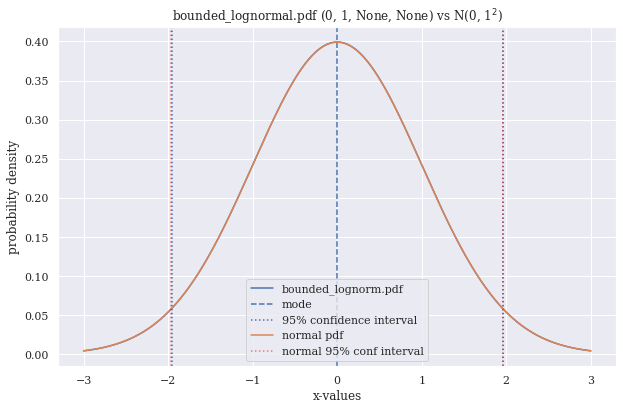

In [ ]:
def compare_to_N(mode, sigma, lower, upper):
    x = np.linspace(mode - sigma * 3, mode + sigma * 3, 1000)
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x, y, label='bounded_lognorm.pdf')
    plt.axvline(mode, ymin=0, linestyle='dashed', label='mode')

    interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
    plt.axvline(interval[0], ymin=0, linestyle='dotted', 
                label='95% confidence interval')
    plt.axvline(interval[1], ymin=0, linestyle='dotted')

    y = norm.pdf(x, loc=mode, scale=sigma)
    sns.lineplot(x,y, label='normal pdf')
    interval2 = norm.interval(0.95, loc=mode, scale=sigma)
    plt.axvline(interval2[0], ymin=0, linestyle='dotted', c='red', alpha=0.5,
                label='normal 95% conf interval')
    plt.axvline(interval2[1], ymin=0, linestyle='dotted', c='red', alpha=0.5)

    title = ('bounded_lognormal.pdf ({}, {}, {}, {}) ' +
            'vs N({}, {}' + r'$^2$' + ')')
    title = title.format(mode, sigma, lower, upper, mode, sigma)
    plt.xlabel("x-values")
    plt.ylabel("probability density")
    plt.title(title)
    plt.legend()
    plt.show()

def compare_quantiles_to_N(mode, sigma, lower, upper):
    sample = bounded_lognorm.rvs(mode, sigma, lower, upper, size=1000)
    a = probplot(sample, dist='norm', sparams=[mode, sigma], plot=None)[0]
    sns.scatterplot(a[0], a[1])
    a_flat = np.asarray(a).flatten()
    extent = np.min(a_flat), np.max(a_flat)
    plt.plot(extent, extent, linewidth=2, alpha=0.3, linestyle='dashed', c='k', 
            label="x=y line")

    plt.xlabel("theoretical quantiles")
    plt.ylabel("sample quantiles")
    title = 'probability plot for bounded_lognorm ({}, {}, {}, {})'
    title = title.format(mode, sigma, lower, upper)
    plt.title(title)
    plt.legend()
    plt.show()

mode, sigma = 0, 1
lower, upper = None, None
compare_to_N(mode, sigma, lower, upper)

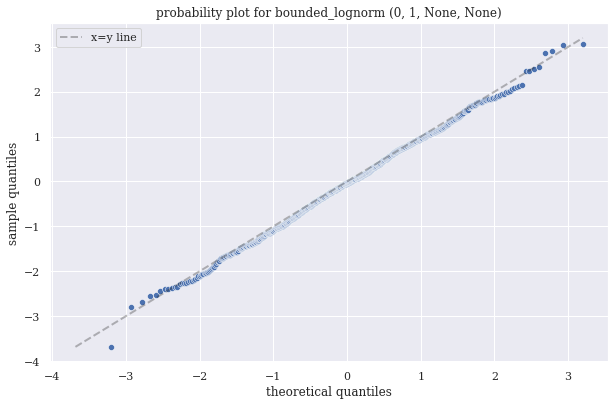

In [ ]:
compare_quantiles_to_N(mode, sigma, lower, upper)

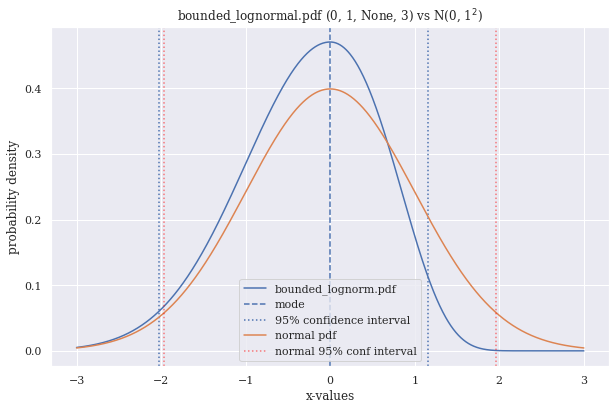

In [ ]:
mode, sigma = 0, 1
lower, upper = None, 3
compare_to_N(mode, sigma, lower, upper)

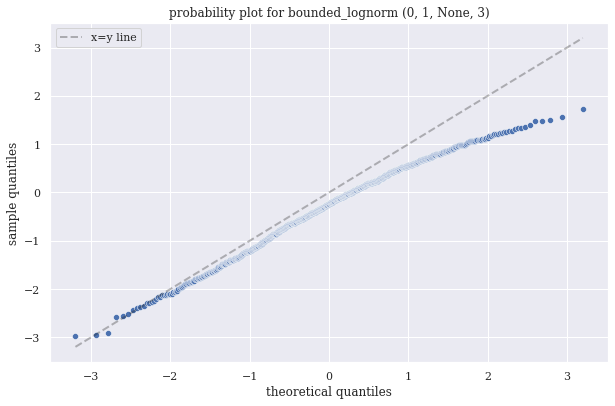

In [ ]:
compare_quantiles_to_N(mode, sigma, lower, upper)

#### The Lognormal Distribution

In [ ]:
def compare_to_LN(spread, log_xscale=False):
    mode, sigma = 1, 1
    lower = 0
    upper = spread
    x = np.linspace(0, 5, 1000)
    
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x, y, label='bounded_lognorm.pdf')
    interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
    plt.axvline(interval[0], ymin=0, linestyle='dashed', 
                label='bounded_lognorm 95% conf. interval')
    plt.axvline(interval[1], ymin=0, linestyle='dashed')

    mu_N, sigma_N = lognorm_params(mode, sigma)
    y = lognorm.pdf(x, loc=0, scale=np.exp(mu_N), s=sigma_N)
    sns.lineplot(x, y, label='lognorm.pdf')
    interval2 = lognorm.interval(0.95, loc=0, scale=np.exp(mu_N), s=sigma_N)
    plt.axvline(interval2[0], ymin=0, linestyle='dashed', c='red', alpha=0.5,
                label='lonorm 95% conf interval')
    plt.axvline(interval2[1], ymin=0, linestyle='dashed', c='red', alpha=0.5)

    if log_xscale:
        plt.xscale('log')
    
    title = ('bounded_lognormal.pdf ({}, {}, {}, {}) ' +
            r'vs lognorm.pdf ($\mu_N, \sigma_N$)')
    title = title.format(mode, sigma, lower, upper)
    plt.xlabel("x-values")
    plt.ylabel("probability density")
    plt.title(title)
    plt.legend()
    plt.show()

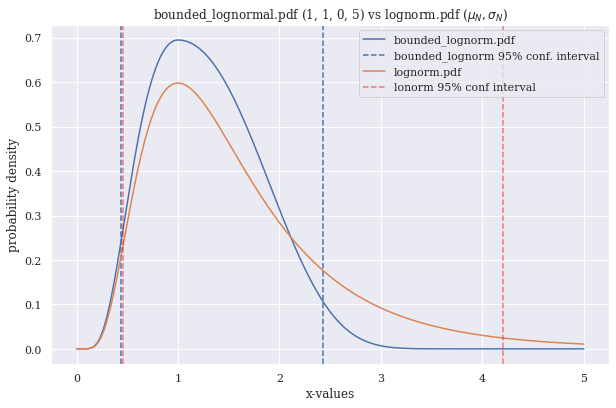

In [ ]:
compare_to_LN(5)

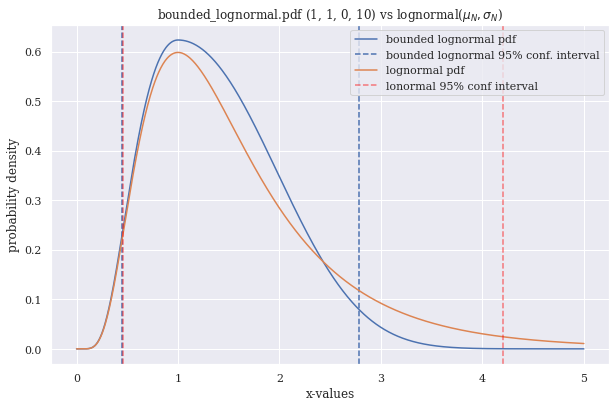

In [ ]:
compare_to_LN(10)

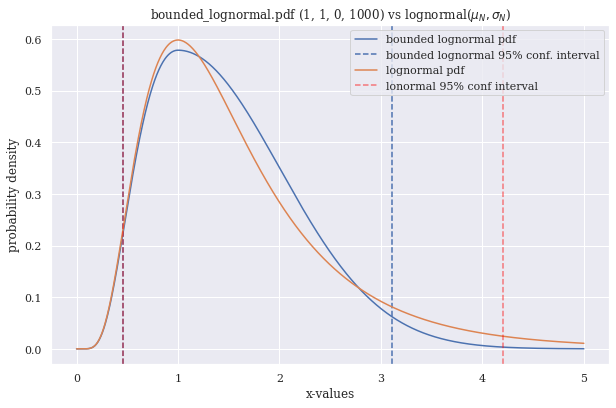

In [ ]:
compare_to_LN(1000)

#### The Truncated Normal Distribution

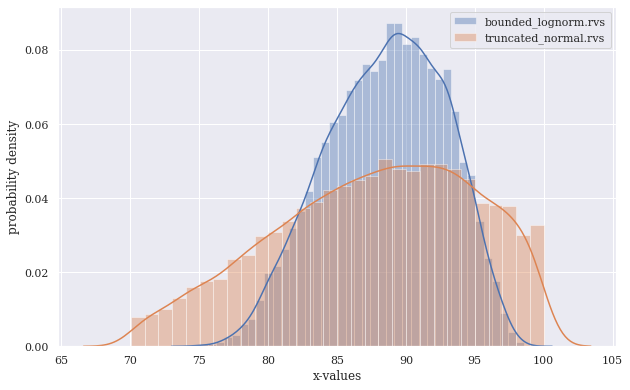

In [ ]:
mode, sigma = 90, 10
lower, upper = 70, 100
sample_size = 10000

sns.distplot(bounded_lognorm.rvs(mode=mode, sigma=sigma, 
                                 lower=lower, upper=upper, size=sample_size),
             label='bounded_lognorm.rvs')
sns.distplot(truncnorm.rvs((lower - mode) / sigma,  
                           (upper - mode) / sigma,
                           mode, sigma, size=sample_size),
             label='truncated_normal.rvs')

plt.xlabel("x-values")
plt.ylabel("probability density")
plt.legend()
plt.show()

#### The Beta, PERT, and modified PERT Distributions


In [106]:
def compare_to_beta(mode, sigma, lower, upper, 
                    gamma=4, xmin=None, xmax=None):
    """
    Plots the bounded_lognorm.pdf against the beta.pdf, matching mode, lower,
    and upper. Here, beta is actually modified PERT (or MPERT), a special case 
    of the beta distribution. See bounded_lognorm.pdf for a description of the 
    parameters mode, sigma, lower, upper.

    Parameters
    ----------
    gamma : float
        weight of mode in mean calculation (default is 4 for PERT[1])
    xmin, xmax : float, float
        range of x-values to plot    
    
    References
    ----------
    [1] https://en.wikipedia.org/wiki/PERT_distribution
    """
    if xmin is None: xmin = lower
    if xmax is None: xmax = upper
    x = np.linspace(xmin, xmax, 1000)
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x, y, label='bounded_lognorm.pdf')
    plt.axvline(mode, ymin=0, linestyle='dashed', label='mode', 
                c='k', alpha=0.5)

    interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
    plt.axvline(interval[0], ymin=0, linestyle='dotted', 
                label='bounded_lognorm 95% conf. interval')
    plt.axvline(interval[1], ymin=0, linestyle='dotted')

    loc, scale = lower, upper - lower
    standardized_mode = (mode - loc) / scale
    a = 1 + gamma * standardized_mode
    b = 1 + gamma * (1 - standardized_mode)
    y = beta.pdf(x, a, b, loc=loc, scale=scale)
    sns.lineplot(x, y, label='beta.pdf')
    interval2 = beta.interval(0.95, a, b, loc=loc, scale=scale)
    plt.axvline(interval2[0], ymin=0, linestyle='dotted', c='red', alpha=0.5,
                label='beta 95% conf. interval')
    plt.axvline(interval2[1], ymin=0, linestyle='dotted', c='red', alpha=0.5)
    
    width_stds = scale / bounded_lognorm.std(mode, sigma, lower, upper)[0]
    width_stds = round(width_stds, 2)
    plt.xlabel("x-values; range in bounded_lognorm.std: {}".format(width_stds))
    plt.ylabel("probability density")
    title = ('bounded_lognorm.pdf ({}, {}, {}, {}) ' + 
             'vs beta.pdf (gamma={})').format(mode, sigma, lower, upper, gamma)
    plt.title(title)
    plt.legend()
    plt.show()

def fit_to_beta(mode, lower, upper, gamma=4, MLE=False):
    loc, scale = lower, upper - lower
    standardized_mode = (mode - loc) / scale
    a = 1 + gamma * standardized_mode
    b = 1 + gamma * (1 - standardized_mode)
    beta_rvs = beta.rvs(a, b, loc=loc, scale=scale, size=1000)
    fixed_params = {'fmode': mode, 'flower': lower, 'fupper': upper}
    sigma_hat = bounded_lognorm.fit(beta_rvs, MLE=MLE, **fixed_params)[1]
    sigma_hat = round(sigma_hat, 2)
    compare_to_beta(mode, sigma_hat, lower, upper, gamma=gamma)

def mod_pert_stats(mode, lower, upper, gamma=4):
    mu = (lower + gamma * mode + upper) / (2 + gamma)
    std = np.sqrt((mu - lower) * (upper - mu) / (3 + gamma)) 
    return mu, std

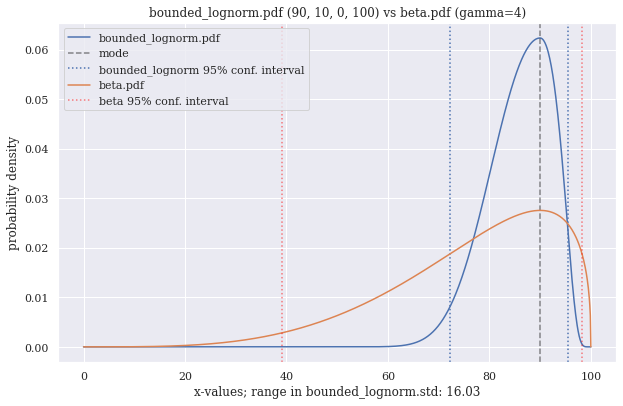

In [57]:
compare_to_beta(90, 10, 0, 100)

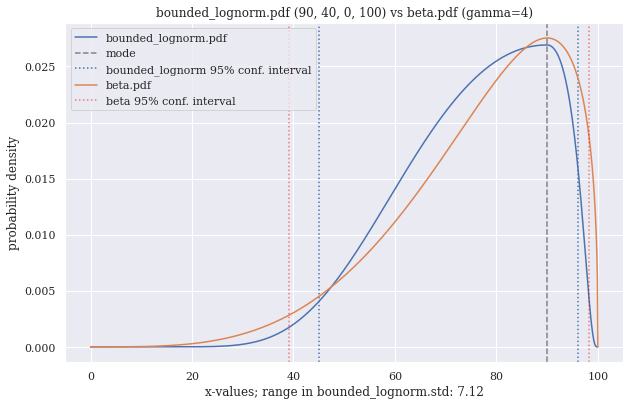

In [58]:
compare_to_beta(90, 40, 0, 100)

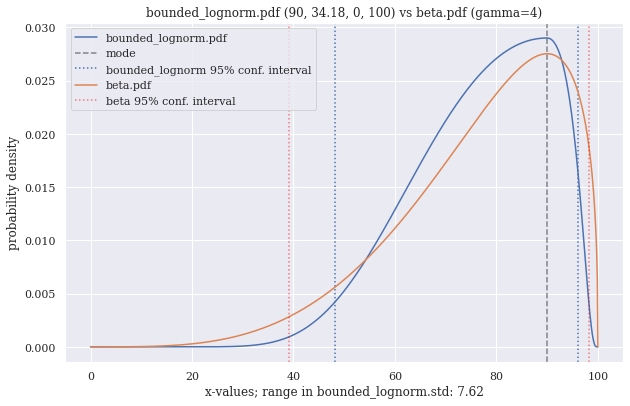

In [61]:
fit_to_beta(90, 0, 100)

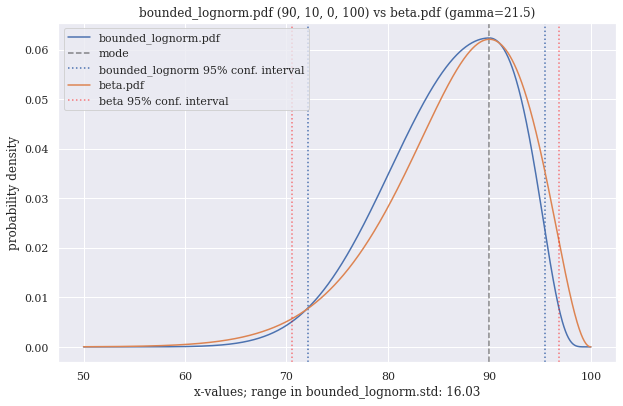

In [101]:
compare_to_beta(90, 10, 0, 100, gamma=21.5, xmin=50)

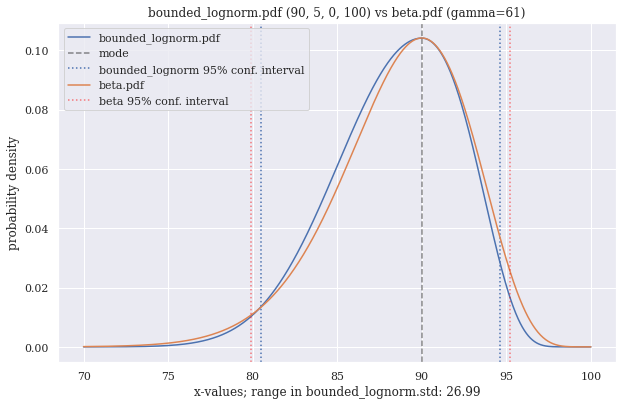

In [102]:
compare_to_beta(90, 5, 0, 100, gamma=61, xmin=70)

In [ ]:
mode, sigma, lower, upper, gamma = 90, 5, 0, 100, 61
beta_mu = (lower + gamma * mode + upper) / (2 + gamma)
beta_mu

88.73015873015873

In [ ]:
bounded_lognorm.mean(mode, sigma, lower, upper)

array([88.48320258])

In [ ]:
beta_std = np.sqrt((beta_mu - lower) * (upper - beta_mu) / (3 + gamma))
beta_std

3.952797278385407

In [ ]:
bounded_lognorm.std(mode, sigma, lower, upper)

array([3.70519447])

What if gamma = 0? Then 0 weight is given to the mode, and standard deviation is the same as that of the uniform distribution over the same support interval. 

In [107]:
mod_pert_stats(mode, lower, upper, gamma=0)[1]

7.216878364870322

In [108]:
uniform_std = np.sqrt((upper - lower)**2 / 12)
uniform_std

7.216878364870322